# Take a closer look at drugs of interest

## Setup

In [1]:
# General imports
import multiprocessing
import numpy as np
import pandas as pd
import time
import sys
import dill
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import collections
import os

# Sklearn imports
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso, ElasticNet
from stability_selection import StabilitySelection
from scipy.stats import pearsonr
# from sklearn.base import clone

/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Add directory to sys.path in order to import custom modules from there.
sys.path.insert(0, "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/Created Modules/")
from gdsc_projects_module import DrugWithDrugBank, DrugGenomeWide, DrugWithGenesInSamePathways, Experiment, Modeling, ModelingResults

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Initialize proper file pathways
drug_annotations = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Drug annotations/Screened_Compounds-March_27th_2018.xlsx"
cell_line_list = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Cell line list (directly from website)/Cell_listThu Aug 16 22_06_49 2018.csv"
gene_expr = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Gene expression/sanger1018_brainarray_ensemblgene_rma-March_2nd_2017.txt"
cnv1 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Copy number variations/cnv_binary_1.csv"
cnv2 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Copy number variations/PANCANCER_Genetic_feature_cna_Mon Aug  6 16_18_51 2018 (kopia).csv"
coding_variants = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Mutation calls/PANCANCER_Genetic_feature_variant_Mon Aug  6 15_45_44 2018.csv"
drug_response = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Sensitivity profiles/v17.3_fitted_dose_response-March_27th_2018.xlsx"

# Load dictionary with targets derived from DrugBank
drugbank_targets = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/DrugBank/Created data/drugbank_map_drug_to_targets.p"

# Load dictionary mapping from target genes to genes that occur in same pathways
reactome_pathway_related_genes = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Reactome/Created Reactome Data/map_target_genes_to_genes_involved_in_same_pathways.pkl"

# Filepath to gene expression signatures provided by Merck
signatures = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Created data/Merck Gene Expression Signatures/Data/SignatureScores_GDSC-cellLines_2018-09-27.tsv"

# Call loading function from DrugWithGenesInSamePathways class
(drug_annotations_df, cell_lines_list_df, gene_expression_df, cnv_binary_df, 
 coding_variants_df, drug_response_df, map_drugs_to_drugbank_targets, 
 map_target_genes_to_same_pathways_genes) = DrugWithGenesInSamePathways.load_data(
    drug_annotations, cell_line_list, gene_expr, 
    cnv1, cnv2, coding_variants, drug_response, drugbank_targets, reactome_pathway_related_genes)

# Load gene expression signatures
signatures_df = pd.read_table(signatures)

# Load helper dict for extraction of CNV data
filepath = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Data/Original Data/Genomics of Drug Sensitivity in Cancer/Original GDSC Data/Copy number variations/Created data/"
with open(filepath + "map_cl_id_and_genetic_feature_to_mutation_status.pkl", "rb") as f:
    map_from_cl_id_and_genetic_feature_to_mutation_status = dill.load(f)


# Load gene mappings
filepath1 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/GDSC - Prediction only with data related to nominal drug targets (minimal approach)/Created data/mapping_from_ensembl_id_to_hgnc_symbol.p"
filepath2 = "/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/GDSC - Prediction only with data related to nominal drug targets (minimal approach)/Created data/mapping_from_hgnc_symbol_to_ensembl_id.p"
with open("../Results Assesment/Results and other files/mapper_from_ensembl_to_hgnc.pkl", "rb") as f:
    map_ensembl_to_hgnc = dill.load(f)
# Initialize class variables
DrugWithDrugBank.load_mappings(filepath2, filepath1)
DrugGenomeWide.load_mappings(filepath2, filepath1)
DrugWithGenesInSamePathways.load_mappings(filepath2, filepath1) 

# Print shapes of created DataFrames
print("Loading summary:")
print("Drug annotations:", drug_annotations_df.shape)
print("Cell line list", cell_lines_list_df.shape)
print("Gene expression", gene_expression_df.shape)
print("CNV binary:", cnv_binary_df.shape)
print("Coding variants:", coding_variants_df.shape)
print("Drug response:", drug_response_df.shape)
print("DrugBank mapping (number of matched drugs):", len(map_drugs_to_drugbank_targets))
print("Target gene mapping (number of target genes with match):", len(map_target_genes_to_same_pathways_genes))
print("Gene expression signatures:", signatures_df.shape)
print("Number of entries in mapping from cell line and cnv genetic feature to mutation status:",
     len(map_from_cl_id_and_genetic_feature_to_mutation_status))

Loading summary:
Drug annotations: (267, 5)
Cell line list (1065, 6)
Gene expression (17737, 1019)
CNV binary: (419050, 9)
Coding variants: (295740, 9)
Drug response: (224202, 13)
DrugBank mapping (number of matched drugs): 88
Target gene mapping (number of target genes with match): 200
Gene expression signatures: (128, 1018)
Number of entries in mapping from cell line and cnv genetic feature to mutation status: 419050


## Load results

In [5]:
# Load list containing IDs of bad drugs
with open("../Results Assesment/Results and other files/bad_drugs.pkl", "rb") as f:
    bad_drugs = dill.load(f)
print(type(bad_drugs), len(bad_drugs))

<class 'list'> 19


In [6]:
# Load results for all settings, not aggregated over data splits
df_raw_all_models = pd.read_csv('../Results Assesment/Results and other files/raw_performance_all_models.csv')
df_raw_all_models_filtered = df_raw_all_models[~df_raw_all_models["Drug ID"].isin(bad_drugs)]
print(df_raw_all_models.shape, df_raw_all_models_filtered.shape)
df_raw_all_models_filtered.head(3)

(12115, 11) (11215, 11)


,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
0,1,Erlotinib,11,0.088977,0.386896,4.561981e-05,0.096257,1.081822,EGFR signaling,OT EN,NaN
1,1,Erlotinib,37,0.061968,0.543188,2.138906e-09,0.070966,1.145203,EGFR signaling,OT EN,NaN
2,1,Erlotinib,52,0.096144,0.422583,7.103247e-06,0.103601,1.077567,EGFR signaling,OT EN,NaN


In [7]:
# Load results for all settings, aggregated over data splits
df_agg_all_models = pd.read_csv('../Results Assesment/Results and other files/aggregated_performance_all_models.csv')
df_agg_all_models_filtered = df_agg_all_models[~df_agg_all_models["Drug ID"].isin(bad_drugs)]
print(df_agg_all_models.shape, df_agg_all_models_filtered.shape)
df_agg_all_models_filtered.head(3)

(2423, 9) (2243, 9)


,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
0,1,Erlotinib,0.086347,0.388664,0.001450,0.0924,1.075011,EGFR signaling,OT EN
1,1,Erlotinib,0.086797,0.356010,0.000767,0.0924,1.062901,EGFR signaling,PG EN
2,1,Erlotinib,0.086307,0.375711,0.000364,0.0924,1.071611,EGFR signaling,PG + S EN


In [8]:
# Load DataFrame with data shapes
data_shapes_df = pd.read_csv("../Results Assesment/Results and other files/data_shapes_per_drug_in_models.csv")
print(data_shapes_df.shape)

(1206, 5)


In [9]:
# Load DataFrame with drugs of interest
df_doi = pd.read_csv("../Results Assesment/Results and other files/drugs_of_interest.csv")
print(df_doi.shape)

(10, 10)


In [10]:
# Load genome-wide ENet ModelingResult object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "genome_wide-enet_over_few_data_splits_without_feature_selection.pkl", "rb") as f:
    genome_wide_without_selection_enet = dill.load(f)
print(type(genome_wide_without_selection_enet), 
      len(genome_wide_without_selection_enet.feat_importances_dict))

<class 'gdsc_projects_module.ModelingResults'> 10


In [11]:
# Load genome-wide ENet with all features ModelingResults object
with open("../Results Assesment/Final experimental raw results/genome_wide_with_all_features-enet_over_few_data_splits_without_feature_selection.pkl", "rb") as f:
    genome_wide_all_features_enet = dill.load(f)
print(type(genome_wide_all_features_enet), len(genome_wide_all_features_enet.performance_dict))

<class 'gdsc_projects_module.ModelingResults'> 11


## Compare genome wide expressions vs genome wide all features for DOI

<class 'gdsc_projects_module.ModelingResults'> 11
(11, 8)


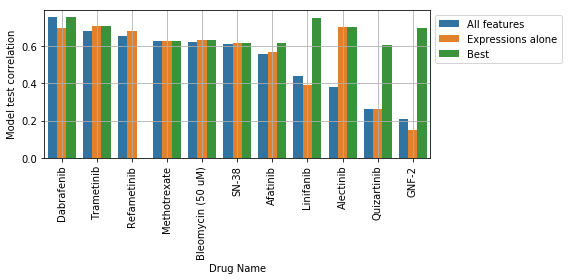

In [12]:
with open("../Results Assesment/Final experimental raw results/genome_wide_with_all_features-enet_over_few_data_splits_without_feature_selection.pkl", "rb") as f:
    results = dill.load(f)
print(type(results), len(results.performance_dict))

cols = ["Model test correlation", "Correlation pval","Model test RMSE", "Dummy test RMSE", "Relative test RMSE", "Target Pathway"]
df_agg = results.create_agg_results_df(cols, "mean", drug_annotations_df)
print(df_agg.shape)
df_agg = df_agg.sort_values("Model test correlation", ascending=False)

# Extract results coming from just expressions
gw_doi = df_agg_all_models[
    df_agg_all_models["Drug ID"].isin(df_agg["Drug ID"].unique())
]
gw_doi = gw_doi[gw_doi.Model == "GW EN"]
gw_doi = gw_doi.sort_values("Model test correlation", ascending=False)

# Concatenate both DataFrames and plot results per drug
df_agg["features"] = "All features"

gw_doi.drop("Model", axis=1, inplace=True)
gw_doi["features"] = "Expressions alone"

doi_best = df_doi.drop(["Model", "No. features"], axis=1)
doi_best["features"] = "Best"

data = pd.concat([df_agg, gw_doi, doi_best])

# Plot results
fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x="Drug Name", y="Model test correlation", hue="features",
                data=data)
ax.tick_params(axis="x", rotation=90)

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.grid()
plt.show()

In [15]:
df_agg_all_models[
    df_agg_all_models["Drug Name"] == "Dabrafenib"
]

,Drug ID,Drug Name,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model
2336,1373,Dabrafenib,0.130606,0.743359,2.503935e-40,0.19328,1.481593,ERK MAPK signaling,PG RF
2337,1373,Dabrafenib,0.127750,0.752645,1.075014e-40,0.19328,1.514006,ERK MAPK signaling,OT + S RF
2338,1373,Dabrafenib,0.150714,0.669706,2.604121e-30,0.20175,1.342379,ERK MAPK signaling,GW SEL EN
2339,1373,Dabrafenib,0.136539,0.716086,2.951282e-32,0.19328,1.420013,ERK MAPK signaling,PG EN
2340,1373,Dabrafenib,0.158293,0.619990,2.089816e-23,0.20175,1.277364,ERK MAPK signaling,GW SEL RF
2341,1373,Dabrafenib,0.132583,0.730844,2.777680e-39,0.19328,1.459840,ERK MAPK signaling,OT EN
2342,1373,Dabrafenib,0.145368,0.697191,4.897866e-34,0.20175,1.390710,ERK MAPK signaling,GW EN
2343,1373,Dabrafenib,0.133422,0.734620,1.133648e-38,0.19328,1.451689,ERK MAPK signaling,OT RF
2344,1373,Dabrafenib,0.130794,0.742562,6.758816e-36,0.19328,1.482108,ERK MAPK signaling,PG + S RF
2345,1373,Dabrafenib,0.132764,0.734083,2.191538e-39,0.19328,1.458098,ERK MAPK signaling,PG + S EN


## Take a look at DOI

In [13]:
df_doi

,Drug ID,Drug Name,Model test correlation,Correlation pval,Relative test RMSE,Model test RMSE,Dummy test RMSE,Model,Target Pathway,No. features
0,1373,Dabrafenib,0.752645,1.075014e-40,1.514006,0.127750,0.193280,OT + S RF,ERK MAPK signaling,136.0
1,1372,Trametinib,0.708743,3.211507e-40,1.404737,0.202283,0.284112,GW EN,ERK MAPK signaling,17737.0
2,277,Linifanib,0.749668,4.346970e-19,1.483354,0.055801,0.080856,OT RF,RTK signaling,7.0
3,281,Alectinib,0.700389,9.898418e-30,1.407981,0.062192,0.086656,GW EN,RTK signaling,17737.0
4,254,Quizartinib,0.604061,3.277115e-05,1.420970,0.061652,0.081050,PG RF,RTK signaling,218.0
5,52,GNF-2,0.698448,2.000000e-01,1.246686,0.043907,0.053700,OT EN,ABL signaling,2.0
6,1377,Afatinib,0.613870,1.163713e-26,1.254071,0.125199,0.157065,OT EN,EGFR signaling,7.0
7,1378,Bleomycin (50 uM),0.633202,2.697727e-29,1.282015,0.196886,0.252266,GW EN,DNA replication,17737.0
8,1008,Methotrexate,0.627378,1.526236e-27,1.273898,0.108074,0.137579,GW EN,DNA replication,17737.0
9,1494,SN-38,0.617248,2.368819e-26,1.274346,0.158217,0.201083,GW EN,DNA replication,17737.0


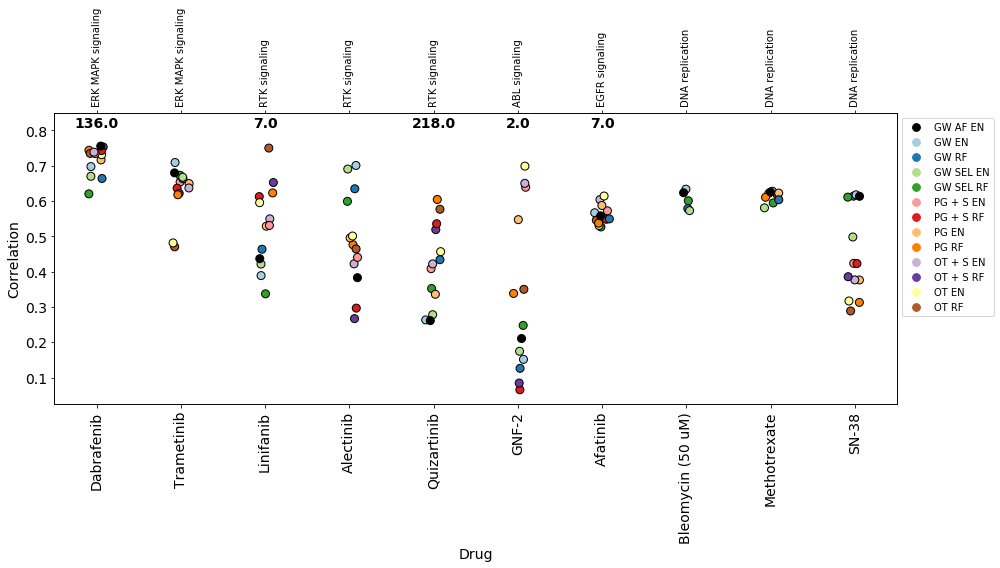

In [14]:
# Plot the DOIs for all models
plt.figure(figsize=(14, 8))

hue_order = ["GW AF EN", "GW EN", "GW RF", "GW SEL EN", "GW SEL RF", "PG + S EN", "PG + S RF", "PG EN","PG RF",
        "OT + S EN", "OT + S RF", "OT EN", "OT RF"]

# Extract drugs of interest from overall DF
df = df_agg_all_models_filtered[
    df_agg_all_models_filtered["Drug ID"].isin(df_doi["Drug ID"].unique())
]

ax = sns.stripplot(x="Drug Name", y="Model test correlation", data=df,
                  hue="Model", hue_order=hue_order,
                  order = df_doi["Drug Name"].unique(), 
                  palette=[(0, 0, 0)] + sns.color_palette("Paired"),
                  size=8,
                  linewidth=1,
                  jitter=True,
                  dodge=False,
                  edgecolor="black")




ax.set_xlabel("Drug", fontsize=14)
ax.set_ylabel("Correlation", fontsize=14)
ax.tick_params(axis='x', labelsize=14, rotation=90)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 0.05)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(ax.get_xticks())
ax2.set_xticklabels(df_doi["Target Pathway"].values)

# Add feature numbers
vertical_position = 0.80
text_color = "black"
text_size = 14

for i in range(df_doi.shape[0]):
    feat_number = df_doi["No. features"].iloc[i]
    if feat_number == 17737:
        continue
    # Determine x and y coordinates
    x = ax.get_xticks()[i]
    ax.text(x, vertical_position, feat_number, ha="center", va="bottom", color=text_color, fontsize=text_size,
           fontweight="bold")


l = ax.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.xticks(rotation=90)
#plt.grid()

plt.tight_layout()

plt.show()

In [16]:
data_shapes_df[
    data_shapes_df["Drug Name"] == "Methotrexate"
]

,Drug ID,Drug Name,Model,No. features,No. samples
1054,1008,Methotrexate,Genome wide ENet,948,849
1055,1008,Methotrexate,Genome wide RForest,100,849
1056,1008,Methotrexate,Pathway genes,70,795
1057,1008,Methotrexate,Pathway genes with signatures,198,795


# Dabrafenib

### Scatterplots predicted vs. actual - GW EN and OT + S RF

In [13]:
# Load corresponding ModelingResults object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "only_targets_with_signatures-rforest_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name)

Only targets with expression signatures - modeling with RForest over few data splits


In [14]:
# Check raw results per splits
mods = ["GW EN", "OT + S RF"]
df_raw_all_models_filtered[
    (df_raw_all_models_filtered["Drug Name"] == "Dabrafenib") & df_raw_all_models_filtered.Model.isin(mods)
].sort_values("Split seed")

,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
3475,1373,Dabrafenib,11,0.123901,0.751688,3.469617e-46,0.185571,1.497731,ERK MAPK signaling,OT + S RF,NaN
10760,1373,Dabrafenib,11,0.132691,0.704866,8.250393e-41,0.186032,1.401993,ERK MAPK signaling,GW EN,NaN
3476,1373,Dabrafenib,37,0.127239,0.787054,2.568335e-53,0.206310,1.621439,ERK MAPK signaling,OT + S RF,NaN
10761,1373,Dabrafenib,37,0.143030,0.718411,4.945566e-43,0.203098,1.419972,ERK MAPK signaling,GW EN,NaN
3477,1373,Dabrafenib,52,0.126886,0.765116,9.577501e-49,0.196563,1.549139,ERK MAPK signaling,OT + S RF,NaN
10762,1373,Dabrafenib,52,0.166852,0.677482,1.107921e-36,0.225895,1.353864,ERK MAPK signaling,GW EN,NaN
3478,1373,Dabrafenib,71,0.135002,0.715233,5.374984e-40,0.191210,1.416352,ERK MAPK signaling,OT + S RF,NaN
10763,1373,Dabrafenib,71,0.134331,0.732314,1.875123e-45,0.195870,1.458109,ERK MAPK signaling,GW EN,NaN
3479,1373,Dabrafenib,98,0.125723,0.744132,8.114751e-45,0.186745,1.485369,ERK MAPK signaling,OT + S RF,NaN
10764,1373,Dabrafenib,98,0.149934,0.652884,2.447825e-33,0.197854,1.319609,ERK MAPK signaling,GW EN,NaN


In [15]:
# Pick a split to work on
drug_tuple = ("Dabrafenib", 1373)
split_seed = 98

estimator_seed_restricted = restricted_results.estimator_seeds[restricted_results.split_seeds.index(split_seed)]
estimator_seed_gw = genome_wide_without_selection_enet.estimator_seeds[genome_wide_without_selection_enet.split_seeds.index(split_seed)]
tuning_seed_restricted = restricted_results.tuning_seeds_dict[drug_tuple][split_seed]
tuning_seed_gw = genome_wide_without_selection_enet.tuning_seeds_dict[drug_tuple][split_seed]

In [16]:
# Perform both modelings
# Generate full data for both models - genome-wide all features
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
drug_gw = drugs[drug_tuple[1]]
del drugs
drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)
drug_restricted = drugs[drug_tuple[1]]
del drugs


# Create full data for GW model
data_types = ["expression"]
data_gw = drug_gw.create_full_data(drug_response_df, data_combination=data_types, 
                                 gene_expression_df=gene_expression_df, 
                                 cnv_binary_df=cnv_binary_df,
                                 map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                 cell_line_list=cell_lines_list_df,
                                 mutation_df=coding_variants_df,
                                 merck_signatures_df=signatures_df)
print("Shape of created GW data:", data_gw.shape)

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue", "merck signatures"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df,
                                     merck_signatures_df=signatures_df)

print("Shape of created restricted data:", data_restricted.shape)

X_train_gw, X_test_gw, X_train_restricted, X_test_restricted, y_train_both, y_test_both = ModelingResults.prepare_data_for_scatter_plots(
data_gw, data_restricted, split_seed)

print("X_train_gw and X_train_restricted shape:", X_train_gw.shape, X_train_restricted.shape)
print("X_test_gw and X_test_restricted shape:", X_test_gw.shape, X_test_restricted.shape)
print("y_both_train and y_both_test shape:", y_train_both.shape, y_test_both.shape)
print(y_test_both.sum())

Shape of created GW data: (875, 17739)
Shape of created restricted data: (823, 150)
X_train_gw and X_train_restricted shape: (576, 17737) (576, 148)
X_test_gw and X_test_restricted shape: (247, 17737) (247, 148)
y_both_train and y_both_test shape: (576,) (247,)
219.30321399999997


In [18]:
# Modeling with best parameters - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

# Extract best parameters
best_params = genome_wide_without_selection_enet.best_params_dict[drug_tuple][split_seed]
#print(best_params)

preds_gw = ModelingResults.model_for_scatter_plots_with_best_params(X_train_gw, X_test_gw, y_train_both, y_test_both, estimator, 
                                   best_params, log=False)

{'estimator__l1_ratio': 0.1, 'estimator__alpha': 0.1}
Test correlation: (0.7062171651853143, 1.2991658637429642e-38)
Test RMSE: 0.1321754129566954


In [ ]:
# Modeling with grid search - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

preds_gw = ModelingResults.model_for_scatter_plots(X_train_gw, X_test_gw, 
                                   y_train_both, y_test_both, estimator,
                                   genome_wide_without_selection_enet.param_grid, 
                                   tuning_seed_restricted,
                                   log=False)

In [19]:
# Modeling with best parameters - restricted

# Extract best parameters
best_params = restricted_results.best_params_dict[drug_tuple][split_seed]
#print(best_params)

estimator = RandomForestRegressor(random_state=estimator_seed_restricted)


preds_restricted = ModelingResults.model_for_scatter_plots_with_best_params(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator, 
                                   best_params, log=False)

{'estimator__n_estimators': 200, 'estimator__min_samples_split': 57, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 'auto', 'estimator__max_depth': 30, 'estimator__criterion': 'mse'}
Test correlation: (0.7441320572062358, 8.1147511800665e-45)
Test RMSE: 0.1257228305849287


In [ ]:
# Modeling with grid search - restricted
estimator = RandomForestRegressor(random_state=estimator_seed_restricted)


preds_restricted = ModelingResults.model_for_scatter_plots(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator,
                                   restricted_results.param_grid, tuning_seed_restricted,
                                   log=False)

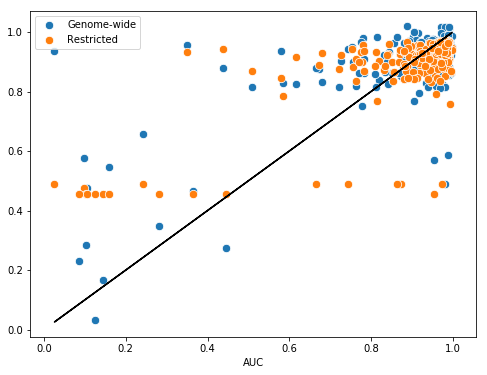

In [23]:
# Plot predicted vs. actual AUC for both models
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(x=y_test_both, y=preds_gw, s=70, label="Genome-wide")
sns.scatterplot(x=y_test_both, y=preds_restricted, s=70, label = "Restricted")
ax.plot(y_test_both, y_test_both, color="black")

plt.show()

### Feature importances - OT + S RF model

In [94]:
# Load corresponding ModelingResults object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "only_targets_with_signatures-rforest_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name, len(restricted_results.performance_dict))

Only targets with expression signatures - modeling with RForest over few data splits 184


In [95]:
# Generate full data for restricted model
drug_name = "Dabrafenib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)
drug_restricted = drugs[drug_id]
del drugs

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue", "merck signatures"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df,
                                     merck_signatures_df=signatures_df)

print("Shape of created restricted data:", data_restricted.shape)

# Initialize proper estimator
estimator = RandomForestRegressor()
importances, cols = restricted_results.extract_feature_importances_across_splits(data_restricted, 
                                                                                     drug_tuple,
                                                                                     estimator, log=False)
print(len(importances), len(cols))
sorted_importances = ModelingResults.sort_feature_importances(importances, cols, 
                                                              map_ensembl_to_hgnc)
print(sorted_importances[:5])

Shape of created restricted data: (823, 150)
148 148
[('BRAF_mut', 0.6169112796269164), ('Kannengiesser.BRAF.signature', 0.053631154439338226), ('Tissue_skin', 0.036934518629678156), ('Breast_ERBB2subtype.Calza2006', 0.020824967505618124), ('MasqueSoler2013_DLBCL_nonMolBL', 0.01782371725418545)]


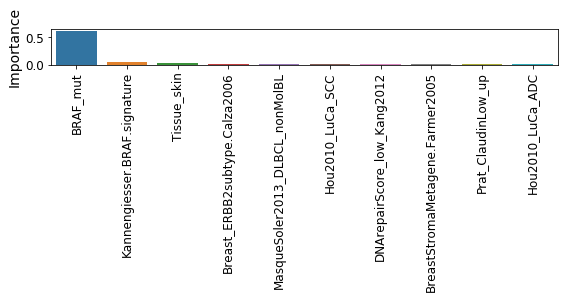

In [96]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

In [97]:
# Find out where BRAF expression ranks
just_names = [x[0] for x in sorted_importances]
print(just_names.index("BRAF_exp") + 1)

28


### Feature importances - GW EN model

In [18]:
# Load previously computed feature importances
drug_name = "Dabrafenib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]

cols = [x[0] for x in importances]
numbers = [x[1] for x in importances]

sorted_importances = ModelingResults.sort_feature_importances(numbers, cols, normalize=False)

print(len(sorted_importances), sorted_importances[:3])

17737 [('MMP8_exp', -0.017261867929832454), ('GAPDHS_exp', -0.012995703697781935), ('ACTBL2_exp', -0.008159722667074713)]


In [129]:
for x, y in sorted_importances:
    print(x, abs(y))
    time.sleep(0.5)

MMP19_exp 0.0019349938680307155
PCYOX1L_exp 0.0018460004543966863
C3orf35_exp 0.0015744335031716212
CACNA1C_exp 0.001477154644355288
LRRN2_exp 0.0013584232665558769
ISOC1_exp 0.0012804762308853438
NANOS3_exp 0.0012354054407427962
ATL1_exp 0.0011297763945689152
RAB3IL1_exp 0.0011070187637749677


KeyboardInterrupt: 

In [126]:
for x, y in sorted_importances:
    print(x, abs(y))
    time.sleep(0.5)

MMP19_exp 0.0019349938680307155
PCYOX1L_exp 0.0018460004543966863
C3orf35_exp 0.0015744335031716212
CACNA1C_exp 0.001477154644355288
LRRN2_exp 0.0013584232665558769
ISOC1_exp 0.0012804762308853438
NANOS3_exp 0.0012354054407427962
ATL1_exp 0.0011297763945689152
RAB3IL1_exp 0.0011070187637749677
TMEM47_exp 0.0010916472736673863
MRGPRF_exp 0.0010904539360718241
USP2_exp 0.0010848773832194867
ADGRD2_exp 0.0010566739294907191


KeyboardInterrupt: 

[('MMP8_exp', -0.017261867929832454),
 ('GAPDHS_exp', -0.012995703697781935),
 ('ACTBL2_exp', -0.008159722667074713)]

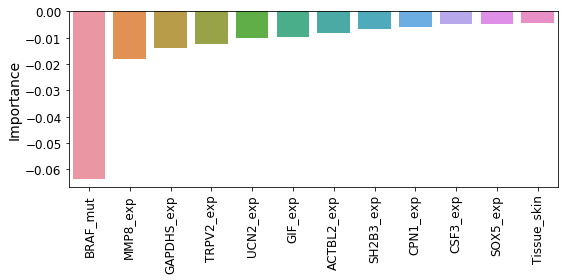

In [34]:
# Plot top k features along with their importances
k = 12

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

In [33]:
# Find out where BRAF expression ranks
just_names = [x[0] for x in sorted_importances]
print(just_names.index("Tissue_skin") + 1)

12


# Trametinib

### Scatterplots predicted vs. actual - GW EN and PG EN

In [14]:
# Load corresponding best ModelingResults object
# Set directory with results
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "pathway_genes-enet_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name)

Pathway genes - modeling with ENet over few data splits


In [15]:
# Check raw results per splits
mods = ["GW EN", "PG EN"]
df_raw_all_models_filtered[
    (df_raw_all_models_filtered["Drug Name"] == "Trametinib") & df_raw_all_models_filtered.Model.isin(mods)
].sort_values("Split seed")

,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
4355,1372,Trametinib,11,0.216024,0.672825,7.726305e-35,0.292455,1.353811,ERK MAPK signaling,PG EN,NaN
10755,1372,Trametinib,11,0.200187,0.699882,4.721092e-41,0.279503,1.396209,ERK MAPK signaling,GW EN,NaN
4356,1372,Trametinib,37,0.219716,0.638462,1.736389e-30,0.284246,1.293697,ERK MAPK signaling,PG EN,NaN
10756,1372,Trametinib,37,0.211822,0.690470,1.424909e-39,0.291300,1.375214,ERK MAPK signaling,GW EN,NaN
4357,1372,Trametinib,52,0.225597,0.654012,2.190686e-32,0.296717,1.315252,ERK MAPK signaling,PG EN,NaN
10757,1372,Trametinib,52,0.201096,0.697064,1.327654e-40,0.279365,1.389210,ERK MAPK signaling,GW EN,NaN
4358,1372,Trametinib,71,0.219914,0.634729,4.780261e-30,0.283629,1.289731,ERK MAPK signaling,PG EN,NaN
10758,1372,Trametinib,71,0.203426,0.745827,3.380344e-49,0.296001,1.455079,ERK MAPK signaling,GW EN,NaN
4359,1372,Trametinib,98,0.220362,0.645258,2.649524e-31,0.288104,1.307408,ERK MAPK signaling,PG EN,NaN
10759,1372,Trametinib,98,0.194882,0.710471,8.680390e-43,0.274389,1.407975,ERK MAPK signaling,GW EN,NaN


In [16]:
# Pick a split to work on
drug_tuple = ("Trametinib", 1372)
split_seed = 11

estimator_seed_restricted = restricted_results.estimator_seeds[restricted_results.split_seeds.index(split_seed)]
estimator_seed_gw = genome_wide_without_selection_enet.estimator_seeds[genome_wide_without_selection_enet.split_seeds.index(split_seed)]
tuning_seed_restricted = restricted_results.tuning_seeds_dict[drug_tuple][split_seed]
tuning_seed_gw = genome_wide_without_selection_enet.tuning_seeds_dict[drug_tuple][split_seed]

In [18]:
# Perform both modelings
# Generate full data for both models
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
drug_gw = drugs[drug_tuple[1]]
del drugs
drugs = DrugWithGenesInSamePathways.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets, 
                                       map_target_genes_to_same_pathways_genes)
drug_restricted = drugs[drug_tuple[1]]
del drugs


# Create full data for GW model
data_gw = drug_gw.return_full_data(drug_response_df, gene_expression_df, data_combination=["expression"])
print("Shape of created GW data:", data_gw.shape)

# Create full data for restricted model
# Set up data classes we want to use
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.return_full_data(drug_response_df,
                     gene_expression_df=gene_expression_df,
                     cnv_binary_df=cnv_binary_df,
                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                     cell_line_list=cell_lines_list_df,
                     mutation_df=coding_variants_df,
                     data_combination=data_types)

print("Shape of created restricted data:", data_restricted.shape)

X_train_gw, X_test_gw, X_train_restricted, X_test_restricted, y_train_both, y_test_both = ModelingResults.prepare_data_for_scatter_plots(
data_gw, data_restricted, split_seed)
print("X_train_gw and X_train_restricted shape:", X_train_gw.shape, X_train_restricted.shape)
print("X_test_gw and X_test_restricted shape:", X_test_gw.shape, X_test_restricted.shape)
print("y_both_train and y_both_test shape:", y_train_both.shape, y_test_both.shape)
print(y_test_both.sum())

/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/Created Modules/gdsc_projects_module.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  obj.sort_values("cell_line_id", inplace=True)


Shape of created GW data: (899, 17739)
Shape of created restricted data: (845, 198)
X_train_gw and X_train_restricted shape: (591, 17737) (591, 196)
X_test_gw and X_test_restricted shape: (254, 17737) (254, 196)
y_both_train and y_both_test shape: (591,) (254,)
172.04805199999998


In [20]:
# Modeling with best parameters - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

# Extract best parameters
best_params = genome_wide_without_selection_enet.best_params_dict[drug_tuple][split_seed]
print(best_params)

preds_gw = ModelingResults.model_for_scatter_plots_with_best_params(X_train_gw, X_test_gw, y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.0, 'estimator__alpha': 50.0}


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Test correlation: (0.6990095161774025, 1.435075955732229e-38)
Test RMSE: 0.21108327926259615


In [ ]:
# Modeling with grid search - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

preds_gw = ModelingResults.model_for_scatter_plots(X_train_gw, X_test_gw, 
                                   y_train_both, y_test_both, estimator,
                                   genome_wide_without_selection_enet.param_grid, 
                                   tuning_seed_restricted,
                                   log=True)

In [22]:
# Modeling with best parameters - restricted

# Extract best parameters
best_params = restricted_results.best_params_dict[drug_tuple][split_seed]
print(best_params)

estimator = RandomForestRegressor(random_state=estimator_seed_restricted)
estimator = ElasticNet(random_state=estimator_seed_restricted)


preds_restricted = ModelingResults.model_for_scatter_plots_with_best_params(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.75, 'estimator__alpha': 0.01}
Test correlation: (0.6728246321693144, 7.726298622244973e-35)
Test RMSE: 0.2160238020407458


In [ ]:
# Modeling with grid search - restricted
estimator = RandomForestRegressor(random_state=estimator_seed_restricted)


preds_restricted = ModelingResults.model_for_scatter_plots(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator,
                                   restricted_results.param_grid, tuning_seed_restricted,
                                   log=True)

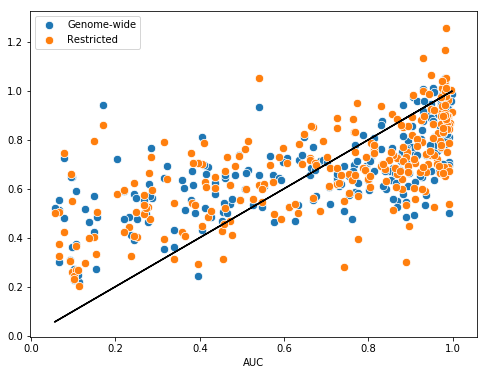

In [23]:
# Plot predicted vs. actual AUC for both models
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(x=y_test_both, y=preds_gw, s=70, label="Genome-wide")
sns.scatterplot(x=y_test_both, y=preds_restricted, s=70, label = "Restricted")
ax.plot(y_test_both, y_test_both, color="black")

plt.show()

### Feature importances - PG EN model

In [124]:
# Load corresponding ModelingResults object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "pathway_genes-enet_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name, len(restricted_results.performance_dict))

Pathway genes - modeling with ENet over few data splits 186


In [125]:
# Generate full data for restricted model
drug_name = "Trametinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

drugs = DrugWithGenesInSamePathways.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets, 
                                       map_target_genes_to_same_pathways_genes)
drug_restricted = drugs[drug_id]
del drugs

# Create full data for restricted model
# Set up data classes we want to use
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.return_full_data(drug_response_df,
                     gene_expression_df=gene_expression_df,
                     cnv_binary_df=cnv_binary_df,
                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                     cell_line_list=cell_lines_list_df,
                     mutation_df=coding_variants_df,
                     data_combination=data_types)


print("Shape of created restricted data:", data_restricted.shape)

# Initialize proper estimator
estimator = ElasticNet()
importances, cols = restricted_results.extract_feature_importances_across_splits(data_restricted, 
                                                                                     drug_tuple,
                                                                                     estimator, log=False)
print(len(importances), len(cols))
sorted_importances = ModelingResults.sort_feature_importances(importances, cols, 
                                                              map_ensembl_to_hgnc)
print(sorted_importances[:5])

Shape of created restricted data: (845, 198)
196 196
[('BRAF_mut', -0.03219147503792921), ('SPRED1_exp', -0.030892316811502635), ('PPP2R5D_exp', 0.024747916132631113), ('NRAS_mut', -0.024651880456679078), ('Tissue_skin', -0.02367186885296426)]


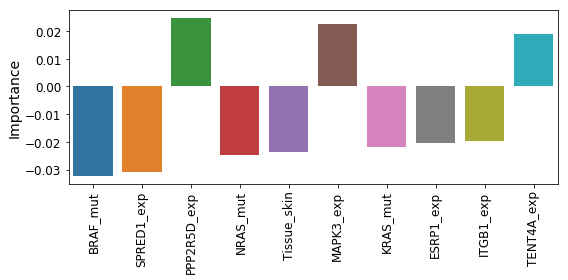

In [126]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW AF EN model

In [127]:
# Load previously computed feature importances
drug_name = "Trametinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_all_features_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

18613 [('NRAS_mut', -0.005371149061119505), ('IGFBP1_exp', -0.004301678557889695), ('GSN_exp', -0.004167897063982022)]


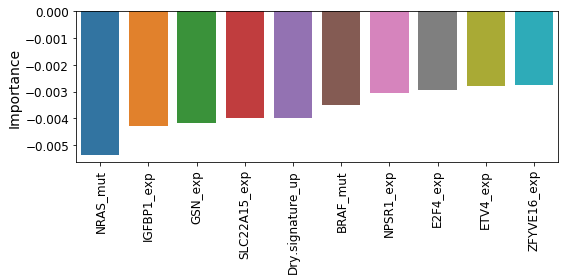

In [128]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW EN model

In [129]:
# Load previously computed feature importances
drug_name = "Trametinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

17737 [('DUSP6_exp', -0.0006250115203519928), ('ETV4_exp', -0.0006176826743928839), ('ETV5_exp', -0.0005968988472436629)]


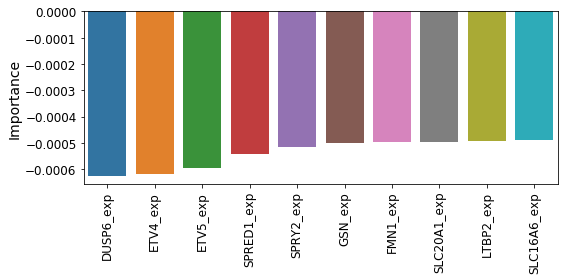

In [130]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

# Alectinib

### Scatterplots predicted vs. actual - GW EN and OT EN

In [25]:
# Load corresponding best ModelingResults object
# Set directory with results
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "only_targets-enet_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name)

Only targets - modeling with ENet over few data splits


In [27]:
# Check raw results per splits
mods = ["GW EN", "OT EN"]
df_raw_all_models_filtered[
    (df_raw_all_models_filtered["Drug Name"] == "Alectinib") & df_raw_all_models_filtered.Model.isin(mods)
].sort_values("Split seed")

,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
420,281,Alectinib,11,0.095132,0.680341,1.101282e-36,0.105335,1.107254,RTK signaling,OT EN,NaN
10170,281,Alectinib,11,0.074545,0.605765,4.949160e-29,0.088187,1.183011,RTK signaling,GW EN,NaN
421,281,Alectinib,37,0.071067,0.230554,1.766215e-04,0.042170,0.593389,RTK signaling,OT EN,NaN
10171,281,Alectinib,37,0.057085,0.726553,1.463381e-46,0.083041,1.454686,RTK signaling,GW EN,NaN
422,281,Alectinib,52,0.070148,0.490673,3.704407e-17,0.079812,1.137757,RTK signaling,OT EN,NaN
10172,281,Alectinib,52,0.056811,0.790245,3.217835e-60,0.092591,1.629811,RTK signaling,GW EN,NaN
423,281,Alectinib,71,0.060191,0.707269,9.681271e-41,0.079803,1.325841,RTK signaling,OT EN,NaN
10173,281,Alectinib,71,0.058891,0.733050,8.998050e-48,0.086237,1.464364,RTK signaling,GW EN,NaN
424,281,Alectinib,98,0.056190,0.394101,4.315611e-11,0.061392,1.092579,RTK signaling,OT EN,NaN
10174,281,Alectinib,98,0.063626,0.646331,4.906213e-34,0.083225,1.308033,RTK signaling,GW EN,NaN


In [28]:
# Pick a split to work on
drug_tuple = ("Alectinib", 281)
split_seed = 52

estimator_seed_restricted = restricted_results.estimator_seeds[restricted_results.split_seeds.index(split_seed)]
estimator_seed_gw = genome_wide_without_selection_enet.estimator_seeds[genome_wide_without_selection_enet.split_seeds.index(split_seed)]
tuning_seed_restricted = restricted_results.tuning_seeds_dict[drug_tuple][split_seed]
tuning_seed_gw = genome_wide_without_selection_enet.tuning_seeds_dict[drug_tuple][split_seed]

In [29]:
# Perform both modelings
# Generate full data for both models
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
drug_gw = drugs[drug_tuple[1]]
del drugs
drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)
drug_restricted = drugs[drug_tuple[1]]
del drugs


# Create full data for GW model
data_gw = drug_gw.return_full_data(drug_response_df, gene_expression_df, data_combination=["expression"])
print("Shape of created GW data:", data_gw.shape)

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df)

print("Shape of created restricted data:", data_restricted.shape)

X_train_gw, X_test_gw, X_train_restricted, X_test_restricted, y_train_both, y_test_both = ModelingResults.prepare_data_for_scatter_plots(
data_gw, data_restricted, split_seed)
print("X_train_gw and X_train_restricted shape:", X_train_gw.shape, X_train_restricted.shape)
print("X_test_gw and X_test_restricted shape:", X_test_gw.shape, X_test_restricted.shape)
print("y_both_train and y_both_test shape:", y_train_both.shape, y_test_both.shape)
print(y_test_both.sum())

/media/krzysztof/Nowy/Doktorat - Modelling drug efficacy in cancer/Projects/Created Modules/gdsc_projects_module.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  obj.sort_values("cell_line_id", inplace=True)


Shape of created GW data: (919, 17739)
Shape of created restricted data: (865, 17)
X_train_gw and X_train_restricted shape: (605, 17737) (605, 15)
X_test_gw and X_test_restricted shape: (260, 17737) (260, 15)
y_both_train and y_both_test shape: (605,) (260,)
248.668853


In [31]:
# Modeling with best parameters - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

# Extract best parameters
best_params = genome_wide_without_selection_enet.best_params_dict[drug_tuple][split_seed]
print(best_params)

preds_gw = ModelingResults.model_for_scatter_plots_with_best_params(X_train_gw, X_test_gw, y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 1.0, 'estimator__alpha': 0.001}
Test correlation: (0.6026600429835735, 4.258204730388212e-27)
Test RMSE: 0.06411011088553963


In [ ]:
# Modeling with grid search - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

preds_gw = ModelingResults.model_for_scatter_plots(X_train_gw, X_test_gw, 
                                   y_train_both, y_test_both, estimator,
                                   genome_wide_without_selection_enet.param_grid, 
                                   tuning_seed_restricted,
                                   log=True)

In [33]:
# Modeling with best parameters - restricted

# Extract best parameters
best_params = restricted_results.best_params_dict[drug_tuple][split_seed]
print(best_params)

estimator = ElasticNet(random_state=estimator_seed_restricted, max_iter=2500)


preds_restricted = ModelingResults.model_for_scatter_plots_with_best_params(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.0, 'estimator__alpha': 1.0}
Test correlation: (0.49067276193312304, 3.704407188183936e-17)
Test RMSE: 0.07014840440537368


/home/krzysztof/anaconda3/envs/modeling_drug_efficacy/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [37]:
# Modeling with grid search - restricted
estimator = ElasticNet(random_state=estimator_seed_restricted, max_iter=2500)

preds_restricted = ModelingResults.model_for_scatter_plots(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator,
                                   restricted_results.param_grid, tuning_seed_restricted,
                                   log=True)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Test correlation: (0.4906727619331229, 3.7044071881840065e-17)
Test RMSE: 0.07014840440537368
{'estimator__l1_ratio': 0.0, 'estimator__alpha': 1.0}


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.8s finished


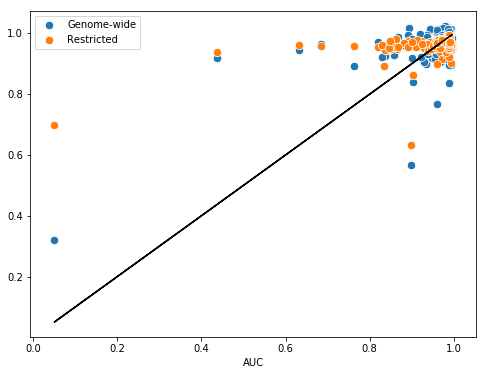

In [38]:
# Plot predicted vs. actual AUC for both models
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(x=y_test_both, y=preds_gw, s=70, label="Genome-wide")
sns.scatterplot(x=y_test_both, y=preds_restricted, s=70, label = "Restricted")
ax.plot(y_test_both, y_test_both, color="black")

plt.show()

### Feature importances - OT EN model

In [131]:
# Load corresponding ModelingResults object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "only_targets-enet_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name, len(restricted_results.performance_dict))

Only targets - modeling with ENet over few data splits 184


In [132]:
# Generate full data for restricted model
drug_name = "Alectinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)
drug_restricted = drugs[drug_tuple[1]]
del drugs

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df)


print("Shape of created restricted data:", data_restricted.shape)

# Initialize proper estimator
estimator = ElasticNet()
importances, cols = restricted_results.extract_feature_importances_across_splits(data_restricted, 
                                                                                     drug_tuple,
                                                                                     estimator, log=False)
print(len(importances), len(cols))
sorted_importances = ModelingResults.sort_feature_importances(importances, cols, 
                                                              map_ensembl_to_hgnc)
print(sorted_importances[:5])

Shape of created restricted data: (865, 17)
15 15
[('ALK_exp', -0.03262759618899827), ('Tissue_blood', -0.006204898241288074), ('Tissue_soft_tissue', 0.005386989092319937), ('Tissue_nervous_system', 0.005152571898831393), ('Tissue_skin', 0.0034090510535359437)]


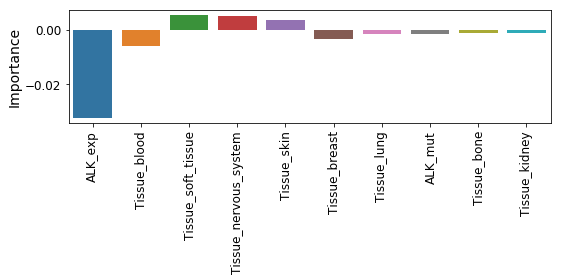

In [133]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW AF EN model

In [134]:
# Load previously computed feature importances
drug_name = "Alectinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_all_features_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

18613 [('ALK_exp', -0.015433356051738008), ('CD163_exp', -0.00889222585720394), ('CD300C_exp', -0.006460375634679429)]


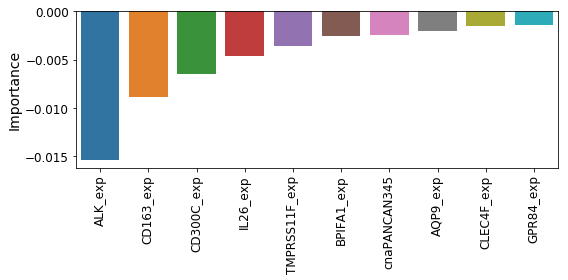

In [135]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW EN model

In [136]:
# Load previously computed feature importances
drug_name = "Alectinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

17737 [('ALK_exp', -0.014227809855841858), ('TMPRSS11F_exp', -0.007180414611220404), ('OCSTAMP_exp', -0.006949585632553201)]


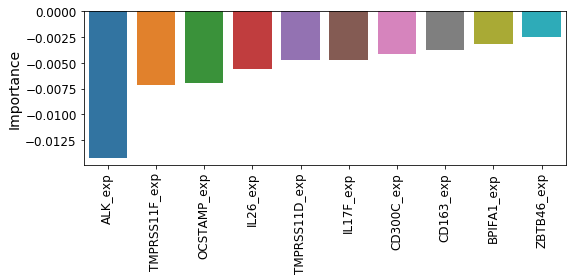

In [137]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

# Quizartinib

### Scatterplots predicted vs. actual - GW EN and PG RF

In [69]:
# Load corresponding best ModelingResults object
# Set directory with results
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "pathway_genes-rforest_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name)

Pathway genes - modeling with RForest over few data splits


In [70]:
# Check raw results per splits
mods = ["GW EN", "PG RF"]
df_raw_all_models_filtered[
    (df_raw_all_models_filtered["Drug Name"] == "Quizartinib") & df_raw_all_models_filtered.Model.isin(mods)
].sort_values("Split seed")

,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
4735,254,Quizartinib,11,0.073301,3.806616e-01,2.347380e-10,0.078624,1.072612,RTK signaling,PG RF,NaN
10065,254,Quizartinib,11,0.081836,9.643163e-02,1.092842e-01,0.068640,0.838758,RTK signaling,GW EN,NaN
4736,254,Quizartinib,37,0.037768,8.305932e-01,2.735819e-67,0.066857,1.770209,RTK signaling,PG RF,NaN
10066,254,Quizartinib,37,0.071848,4.906194e-01,3.488047e-18,0.081687,1.136939,RTK signaling,GW EN,NaN
4737,254,Quizartinib,52,0.038490,8.476313e-01,1.071169e-72,0.068481,1.779193,RTK signaling,PG RF,NaN
10067,254,Quizartinib,52,0.058246,2.429725e-15,1.000000e+00,0.058246,1.000000,RTK signaling,GW EN,NaN
4738,254,Quizartinib,71,0.092167,2.321149e-01,1.638555e-04,0.093837,1.018126,RTK signaling,PG RF,NaN
10068,254,Quizartinib,71,0.085954,5.240838e-01,6.061618e-21,0.094770,1.102560,RTK signaling,GW EN,NaN
4739,254,Quizartinib,98,0.066532,7.293060e-01,2.966266e-44,0.097450,1.464711,RTK signaling,PG RF,NaN
10069,254,Quizartinib,98,0.068754,2.044163e-01,6.193487e-04,0.061143,0.889301,RTK signaling,GW EN,NaN


In [71]:
# Pick a split to work on
drug_tuple = ("Quizartinib", 254)
split_seed = 52

estimator_seed_restricted = restricted_results.estimator_seeds[restricted_results.split_seeds.index(split_seed)]
estimator_seed_gw = genome_wide_without_selection_enet.estimator_seeds[genome_wide_without_selection_enet.split_seeds.index(split_seed)]
tuning_seed_restricted = restricted_results.tuning_seeds_dict[drug_tuple][split_seed]
tuning_seed_gw = genome_wide_without_selection_enet.tuning_seeds_dict[drug_tuple][split_seed]

In [72]:
# Perform both modelings
# Generate full data for both models
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
drug_gw = drugs[drug_tuple[1]]
del drugs
drugs = DrugWithGenesInSamePathways.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets, 
                                       map_target_genes_to_same_pathways_genes)
drug_restricted = drugs[drug_tuple[1]]
del drugs


# Create full data for GW model
data_gw = drug_gw.return_full_data(drug_response_df, gene_expression_df, data_combination=["expression"])
print("Shape of created GW data:", data_gw.shape)

# Create full data for restricted model
# Set up data classes we want to use
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.return_full_data(drug_response_df,
                     gene_expression_df=gene_expression_df,
                     cnv_binary_df=cnv_binary_df,
                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                     cell_line_list=cell_lines_list_df,
                     mutation_df=coding_variants_df,
                     data_combination=data_types)

print("Shape of created restricted data:", data_restricted.shape)

X_train_gw, X_test_gw, X_train_restricted, X_test_restricted, y_train_both, y_test_both = ModelingResults.prepare_data_for_scatter_plots(
data_gw, data_restricted, split_seed)
print("X_train_gw and X_train_restricted shape:", X_train_gw.shape, X_train_restricted.shape)
print("X_test_gw and X_test_restricted shape:", X_test_gw.shape, X_test_restricted.shape)
print("y_both_train and y_both_test shape:", y_train_both.shape, y_test_both.shape)
print(y_test_both.sum())

Shape of created GW data: (921, 17739)
Shape of created restricted data: (862, 232)
X_train_gw and X_train_restricted shape: (603, 17737) (603, 230)
X_test_gw and X_test_restricted shape: (259, 17737) (259, 230)
y_both_train and y_both_test shape: (603,) (259,)
249.55792100000002


In [46]:
# Modeling with best parameters - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

# Extract best parameters
best_params = genome_wide_without_selection_enet.best_params_dict[drug_tuple][split_seed]
print(best_params)

preds_gw = ModelingResults.model_for_scatter_plots_with_best_params(X_train_gw, X_test_gw, y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.75, 'estimator__alpha': 1.0}
Test correlation: (1.8451940542645402e-15, 1.0)
Test RMSE: 0.06848084708568894


In [ ]:
# Modeling with grid search - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

preds_gw = ModelingResults.model_for_scatter_plots(X_train_gw, X_test_gw, 
                                   y_train_both, y_test_both, estimator,
                                   genome_wide_without_selection_enet.param_grid, 
                                   tuning_seed_restricted,
                                   log=True)

In [49]:
# Modeling with best parameters - restricted

# Extract best parameters
best_params = restricted_results.best_params_dict[drug_tuple][split_seed]
print(best_params)

estimator = RandomForestRegressor(random_state=estimator_seed_restricted)


preds_restricted = ModelingResults.model_for_scatter_plots_with_best_params(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__n_estimators': 100, 'estimator__min_samples_split': 79, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 'auto', 'estimator__max_depth': 80, 'estimator__criterion': 'mse'}
Test correlation: (0.8476245760104115, 1.0767759702127457e-72)
Test RMSE: 0.03849055477782701


In [48]:
# Modeling with grid search - restricted
estimator = RandomForestRegressor(random_state=estimator_seed_restricted)


preds_restricted = ModelingResults.model_for_scatter_plots(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator,
                                   restricted_results.param_grid, tuning_seed_restricted,
                                   log=True)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.8min finished


Test correlation: (0.8476245760104115, 1.0767759702127457e-72)
Test RMSE: 0.03849055477782701
{'estimator__n_estimators': 100, 'estimator__min_samples_split': 79, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 'auto', 'estimator__max_depth': 80, 'estimator__criterion': 'mse'}


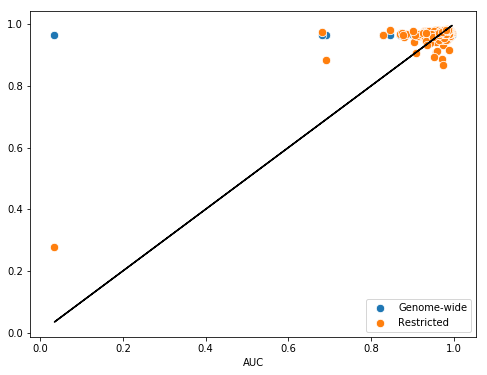

In [50]:
# Plot predicted vs. actual AUC for both models
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(x=y_test_both, y=preds_gw, s=70, label="Genome-wide")
sns.scatterplot(x=y_test_both, y=preds_restricted, s=70, label = "Restricted")
ax.plot(y_test_both, y_test_both, color="black")

plt.show()

In [73]:
# Check out samples in detail
print(y_test_both.sort_values()[:5])

857    0.034559
99     0.682729
422    0.690372
3      0.828182
634    0.847085
Name: AUC, dtype: float64


In [74]:
data_restricted[data_restricted.AUC == 0.034559]

,cell_line_id,DLG1_mut,EGFR_mut,ERBB2_mut,ERBB3_mut,FGFR2_mut,FLT3_mut,HGF_mut,HRAS_mut,KIT_mut,...,Tissue_digestive_system,Tissue_kidney,Tissue_lung,Tissue_nervous_system,Tissue_pancreas,Tissue_skin,Tissue_soft_tissue,Tissue_thyroid,Tissue_urogenital_system,AUC
805,1330947,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.034559


In [75]:
# Write important cell lines ID
sensitive_cell_lines = [1330947]

In [76]:
col_mapper = {}
for col in data_restricted.columns:
    if col in map_ensembl_to_hgnc:
        col_mapper[col] = map_ensembl_to_hgnc[col]
    else:
        col_mapper[col] = col
print(len(col_mapper))

232


In [77]:
data_restricted = data_restricted.rename(columns=col_mapper)
data_restricted.head(3)

,cell_line_id,DLG1_mut,EGFR_mut,ERBB2_mut,ERBB3_mut,FGFR2_mut,FLT3_mut,HGF_mut,HRAS_mut,KIT_mut,...,Tissue_digestive_system,Tissue_kidney,Tissue_lung,Tissue_nervous_system,Tissue_pancreas,Tissue_skin,Tissue_soft_tissue,Tissue_thyroid,Tissue_urogenital_system,AUC
0,683665,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.971214
1,683667,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.984283
2,684052,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.990279


In [78]:
X_train_restricted = X_train_restricted.rename(columns=col_mapper)
print(X_train_restricted.shape)

(603, 230)


In [79]:
print(X_train_restricted.shape)
restricted_data_train = data_restricted.loc[X_train_restricted.index]
print(restricted_data_train.shape)

print(X_test_restricted.shape)
restricted_data_test = data_restricted.loc[X_test_restricted.index]
print(restricted_data_test.shape)

(603, 230)
(603, 232)
(259, 230)
(259, 232)


In [80]:
restricted_data_train[["FLT3_exp", "MET_exp", "DLG4_exp"]].std()

FLT3_exp    1.196213
MET_exp     1.217245
DLG4_exp    0.306821
dtype: float64

In [81]:
restricted_data_train[["FLT3_exp", "MET_exp", "DLG4_exp"]].mean()

FLT3_exp    3.262440
MET_exp     4.724245
DLG4_exp    3.366013
dtype: float64

In [82]:
sensitive_df = restricted_data_test[restricted_data_test.cell_line_id.isin(sensitive_cell_lines)]
sensitive_df[["FLT3_exp", "MET_exp", "DLG4_exp"]].mean()

FLT3_exp    11.202837
MET_exp      3.370773
DLG4_exp     3.742189
dtype: float64

In [83]:
# Rename columns of data gw
col_mapper = {}
for col in data_gw.columns:
    if col in map_ensembl_to_hgnc:
        col_mapper[col] = map_ensembl_to_hgnc[col]
    else:
        col_mapper[col] = col
print(len(col_mapper))

17739


In [84]:
data_gw = data_gw.rename(columns=col_mapper)
data_gw.head()

,cell_line_id,TSPAN6_exp,TNMD_exp,DPM1_exp,SCYL3_exp,C1orf112_exp,FGR_exp,CFH_exp,FUCA2_exp,GCLC_exp,...,PPY2P_exp,ENSG00000265246,ENSG00000265298,KRT18P55_exp,MIR5195_exp,POLRMTP1_exp,UBL5P2_exp,TBC1D3P5_exp,ENSG00000266753,AUC
0,683665,3.23827,2.98225,10.2355,4.85606,4.07887,9.11624,3.65859,6.14548,5.04246,...,3.09572,3.50251,8.56432,3.27437,4.01807,3.05621,9.44631,3.53087,6.13427,0.971214
1,683667,7.78071,2.75325,9.96014,4.35107,3.71674,3.22228,8.22161,3.82347,4.75623,...,3.23071,3.03245,9.04097,3.10209,2.87087,3.16919,9.81043,3.26691,8.45208,0.984283
2,684052,7.30134,2.89053,9.92249,4.12509,3.67899,3.09658,3.58839,4.8093,4.95178,...,3.00352,2.87474,8.53276,3.06819,2.87407,3.13548,9.07322,3.09836,6.82424,0.990279
3,684055,8.6902,3.09147,9.99249,4.5722,3.33339,3.32079,3.15949,3.51511,5.44636,...,3.11474,3.12052,8.59165,3.11965,2.58867,3.19493,9.01322,3.07419,8.17305,0.828182
4,684057,8.2331,2.82469,10.0159,4.74971,3.83943,3.14275,5.32983,3.27212,5.53806,...,3.03186,3.37046,8.93082,3.32245,3.08392,2.81344,8.8932,3.26618,8.75829,0.925956


In [85]:
important_gw_genes = ["TIFAB_exp", "OCSTAMP_exp", "PPP1R27_exp", "FLT3_exp", "TRH_exp"]
print(X_train_gw.shape)
gw_data_train = data_gw.loc[X_train_gw.index]
print(gw_data_train.shape)

print(X_test_gw.shape)
gw_data_test = data_gw.loc[X_test_gw.index]
print(gw_data_test.shape)

(603, 17737)
(603, 17739)
(259, 17737)
(259, 17739)


In [86]:
# Check out std and mean in training gw data for important gw genes
gw_data_train[important_gw_genes].std()

TIFAB_exp      0.328189
OCSTAMP_exp    0.356156
PPP1R27_exp    0.722327
FLT3_exp       1.196213
TRH_exp        0.290638
dtype: float64

In [87]:
gw_data_train[important_gw_genes].mean()

TIFAB_exp      2.864238
OCSTAMP_exp    3.022385
PPP1R27_exp    3.202109
FLT3_exp       3.262440
TRH_exp        3.032085
dtype: float64

In [88]:
sensitive_df = gw_data_test[gw_data_test.cell_line_id.isin(sensitive_cell_lines)]
sensitive_df[["cell_line_id"] + important_gw_genes]

,cell_line_id,TIFAB_exp,OCSTAMP_exp,PPP1R27_exp,FLT3_exp,TRH_exp
857,1330947,4.86358,9.50691,10.7302,11.2028,3.09086


In [89]:
sensitive_df[important_gw_genes].mean()

TIFAB_exp       4.863582
OCSTAMP_exp     9.506912
PPP1R27_exp    10.730213
FLT3_exp       11.202837
TRH_exp         3.090857
dtype: float64

In [90]:
sensitive_df[important_gw_genes].mean() / gw_data_train[important_gw_genes].std()

TIFAB_exp      14.819451
OCSTAMP_exp    26.693129
PPP1R27_exp    14.855069
FLT3_exp        9.365251
TRH_exp        10.634722
dtype: float64

### Feature importances - OT RF model

### Feature importances - PG RF model

In [91]:
# Load corresponding ModelingResults object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "pathway_genes-rforest_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name, len(restricted_results.performance_dict))

Pathway genes - modeling with RForest over few data splits 186


In [92]:
# Generate full data for restricted model
drug_name = "Quizartinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

drugs = DrugWithGenesInSamePathways.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets, 
                                       map_target_genes_to_same_pathways_genes)
drug_restricted = drugs[drug_tuple[1]]
del drugs

# Create full data for restricted model
# Set up data classes we want to use
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.return_full_data(drug_response_df,
                     gene_expression_df=gene_expression_df,
                     cnv_binary_df=cnv_binary_df,
                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                     cell_line_list=cell_lines_list_df,
                     mutation_df=coding_variants_df,
                     data_combination=data_types)

print("Shape of created restricted data:", data_restricted.shape)

# Initialize proper estimator
estimator = RandomForestRegressor()
importances, cols = restricted_results.extract_feature_importances_across_splits(data_restricted, 
                                                                                     drug_tuple,
                                                                                     estimator, log=False)
print(len(importances), len(cols))
sorted_importances = ModelingResults.sort_feature_importances(importances, cols, 
                                                              map_ensembl_to_hgnc)
print(sorted_importances[:5])

Shape of created restricted data: (862, 232)
230 230
[('FLT3_exp', 0.403708710678759), ('MET_exp', 0.08480018830648878), ('DLG4_exp', 0.04453788717919625), ('PRTN3_exp', 0.036413782247708824), ('PDGFRA_exp', 0.033552963245340316)]


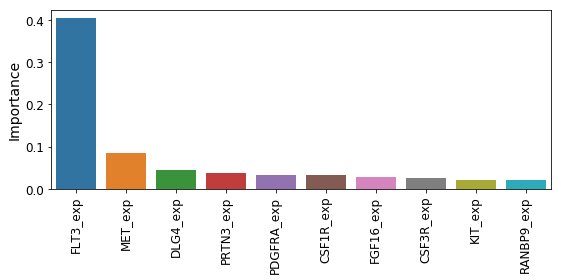

In [93]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

In [95]:
names = [x[0] for x in sorted_importances]
names.index("FLT3_mut")

191

### Feature importances - GW AF EN model

In [142]:
# Load previously computed feature importances
drug_name = "Quizartinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_all_features_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

18613 [('PPP1R27_exp', -0.0057503665326955255), ('OCSTAMP_exp', -0.004128230843722165), ('MLL-AFF1_mut', -0.0031802486087364663)]


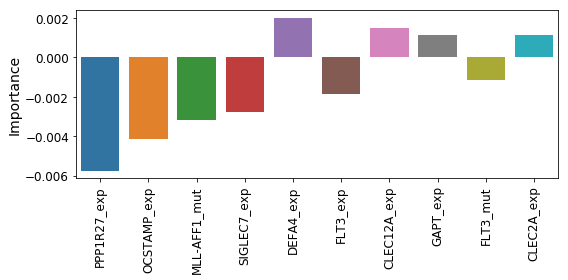

In [143]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW EN model

In [144]:
# Load previously computed feature importances
drug_name = "Quizartinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

17737 [('TIFAB_exp', -0.005359550071194741), ('OCSTAMP_exp', -0.004975209911110003), ('PPP1R27_exp', -0.004083657651813298)]


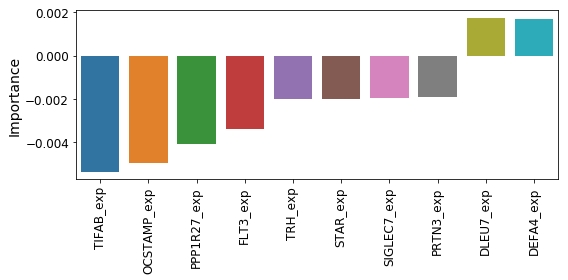

In [145]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

# GNF-2

### Scatterplots predicted vs. actual - GW EN and OT EN

In [52]:
# Load corresponding best ModelingResults object
# Set directory with results
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "only_targets-enet_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name)

Only targets - modeling with ENet over few data splits


In [54]:
# Check raw results per splits
mods = ["GW EN", "OT EN"]
df_raw_all_models_filtered[
    (df_raw_all_models_filtered["Drug Name"] == "GNF-2") & df_raw_all_models_filtered.Model.isin(mods)
].sort_values("Split seed")

,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
80,52,GNF-2,11,0.032222,0.859008,1.793864e-33,0.044832,1.391357,ABL signaling,OT EN,NaN
9635,52,GNF-2,11,0.045942,0.200543,2.875419e-02,0.042876,0.933276,ABL signaling,GW EN,NaN
81,52,GNF-2,37,0.050240,0.605879,1.847125e-12,0.063301,1.259968,ABL signaling,OT EN,NaN
9636,52,GNF-2,37,0.041787,0.165999,7.118959e-02,0.041916,1.003082,ABL signaling,GW EN,NaN
82,52,GNF-2,52,0.057083,NaN,1.000000e+00,0.057083,1.000000,ABL signaling,OT EN,NaN
9637,52,GNF-2,52,0.049280,0.167874,6.801085e-02,0.047550,0.964897,ABL signaling,GW EN,NaN
83,52,GNF-2,71,0.040107,0.722985,3.260885e-19,0.054050,1.347640,ABL signaling,OT EN,NaN
9638,52,GNF-2,71,0.043897,0.071286,4.410580e-01,0.041878,0.954015,ABL signaling,GW EN,NaN
84,52,GNF-2,98,0.039884,0.605918,1.839566e-12,0.049236,1.234464,ABL signaling,OT EN,NaN
9639,52,GNF-2,98,0.059968,NaN,1.000000e+00,0.059968,1.000000,ABL signaling,GW EN,NaN


In [55]:
# Pick a split to work on
drug_tuple = ("GNF-2", 52)
split_seed = 11

estimator_seed_restricted = restricted_results.estimator_seeds[restricted_results.split_seeds.index(split_seed)]
estimator_seed_gw = genome_wide_without_selection_enet.estimator_seeds[genome_wide_without_selection_enet.split_seeds.index(split_seed)]
tuning_seed_restricted = restricted_results.tuning_seeds_dict[drug_tuple][split_seed]
tuning_seed_gw = genome_wide_without_selection_enet.tuning_seeds_dict[drug_tuple][split_seed]

In [56]:
# Perform both modelings
# Generate full data for both models
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
drug_gw = drugs[drug_tuple[1]]
del drugs
drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)
drug_restricted = drugs[drug_tuple[1]]
del drugs


# Create full data for GW model
data_gw = drug_gw.return_full_data(drug_response_df, gene_expression_df, data_combination=["expression"])
print("Shape of created GW data:", data_gw.shape)

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df)

print("Shape of created restricted data:", data_restricted.shape)

X_train_gw, X_test_gw, X_train_restricted, X_test_restricted, y_train_both, y_test_both = ModelingResults.prepare_data_for_scatter_plots(
data_gw, data_restricted, split_seed)
print("X_train_gw and X_train_restricted shape:", X_train_gw.shape, X_train_restricted.shape)
print("X_test_gw and X_test_restricted shape:", X_test_gw.shape, X_test_restricted.shape)
print("y_both_train and y_both_test shape:", y_train_both.shape, y_test_both.shape)
print(y_test_both.sum())

Shape of created GW data: (396, 17739)
Shape of created restricted data: (370, 16)
X_train_gw and X_train_restricted shape: (259, 17737) (259, 14)
X_test_gw and X_test_restricted shape: (111, 17737) (111, 14)
y_both_train and y_both_test shape: (259,) (111,)
108.05202199999998


In [57]:
# Modeling with best parameters - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

# Extract best parameters
best_params = genome_wide_without_selection_enet.best_params_dict[drug_tuple][split_seed]
print(best_params)

preds_gw = ModelingResults.model_for_scatter_plots_with_best_params(X_train_gw, X_test_gw, y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.0, 'estimator__alpha': 5.0}
Test correlation: (0.3022805831341313, 0.0012621372797087809)
Test RMSE: 0.043682294931597726


In [ ]:
# Modeling with grid search - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

preds_gw = ModelingResults.model_for_scatter_plots(X_train_gw, X_test_gw, 
                                   y_train_both, y_test_both, estimator,
                                   genome_wide_without_selection_enet.param_grid, 
                                   tuning_seed_restricted,
                                   log=True)

In [59]:
# Modeling with best parameters - restricted

# Extract best parameters
best_params = restricted_results.best_params_dict[drug_tuple][split_seed]
print(best_params)

estimator = ElasticNet(random_state=estimator_seed_restricted)


preds_restricted = ModelingResults.model_for_scatter_plots_with_best_params(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.0, 'estimator__alpha': 1.0}
Test correlation: (0.8590079499497195, 1.793864135408486e-33)
Test RMSE: 0.032221568448188784


In [ ]:
# Modeling with grid search - restricted
estimator = RandomForestRegressor(random_state=estimator_seed_restricted)


preds_restricted = ModelingResults.model_for_scatter_plots(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator,
                                   restricted_results.param_grid, tuning_seed_restricted,
                                   log=True)

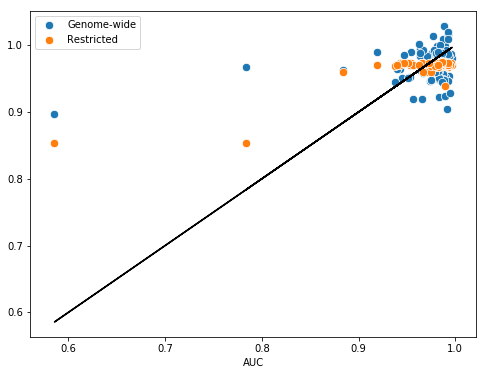

In [60]:
# Plot predicted vs. actual AUC for both models
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(x=y_test_both, y=preds_gw, s=70, label="Genome-wide")
sns.scatterplot(x=y_test_both, y=preds_restricted, s=70, label = "Restricted")
ax.plot(y_test_both, y_test_both, color="black")

plt.show()

### Feature importances - OT EN model

In [146]:
# Load corresponding ModelingResults object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "only_targets-enet_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name, len(restricted_results.performance_dict))

Only targets - modeling with ENet over few data splits 184


In [147]:
# Generate full data for restricted model
drug_name = "GNF-2"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)
drug_restricted = drugs[drug_tuple[1]]
del drugs

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df)

print("Shape of created restricted data:", data_restricted.shape)

# Initialize proper estimator
estimator = ElasticNet()
importances, cols = restricted_results.extract_feature_importances_across_splits(data_restricted, 
                                                                                     drug_tuple,
                                                                                     estimator, log=False)
print(len(importances), len(cols))
sorted_importances = ModelingResults.sort_feature_importances(importances, cols, 
                                                              map_ensembl_to_hgnc)
print(sorted_importances[:5])

Shape of created restricted data: (370, 16)
14 14
[('BCR-ABL_mut', -0.014622528367800296), ('Tissue_kidney', -0.0006602930529933557), ('Tissue_pancreas', -0.0003968669072671901), ('Tissue_lung', 0.00018371906129265318), ('Tissue_bone', -0.00015550395791404364)]


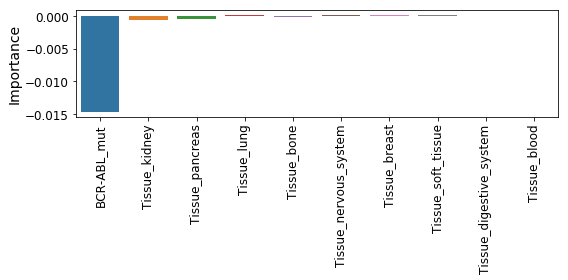

In [148]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW AF EN model

In [149]:
# Load previously computed feature importances
drug_name = "GNF-2"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_all_features_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

18613 [('BCR-ABL_mut', -0.00017221576203193043), ('MYH14_mut', -0.00010983710270312862), ('CFAP161_exp', -0.00010777668144638889)]


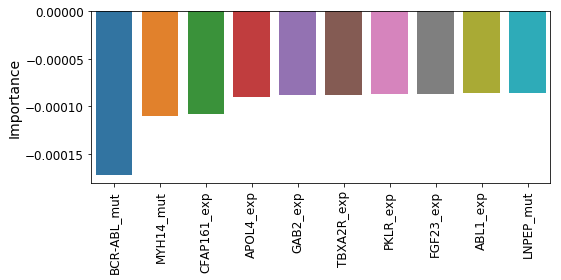

In [150]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW EN model

In [151]:
# Load previously computed feature importances
drug_name = "GNF-2"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

17737 [('LCN8_exp', -0.00017445433935290097), ('TBXA2R_exp', -0.0001692461146254265), ('APOL4_exp', -0.0001657693399954755)]


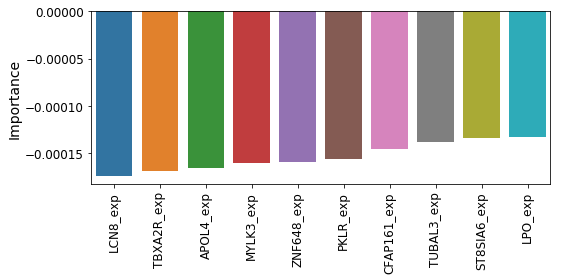

In [152]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

# Methotrexate

### Scatterplots predicted vs. actual - GW EN and PG EN

In [20]:
# Load corresponding best ModelingResults object
# Set directory with results
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "pathway_genes-enet_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name)
print(len(restricted_results.performance_dict))

Pathway genes - modeling with ENet over few data splits
186


In [22]:
# Check raw results per splits
mods = ["GW EN", "PG EN"]
df_raw_all_models_filtered[
    (df_raw_all_models_filtered["Drug Name"] == "Methotrexate") & df_raw_all_models_filtered.Model.isin(mods)
].sort_values("Split seed")

,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
4060,1008,Methotrexate,11,0.101884,0.644310,1.988689e-29,0.130944,1.285225,DNA replication,PG EN,NaN
10375,1008,Methotrexate,11,0.109954,0.629334,1.563549e-29,0.141435,1.286311,DNA replication,GW EN,NaN
4061,1008,Methotrexate,37,0.108540,0.578550,9.423523e-23,0.132856,1.224028,DNA replication,PG EN,NaN
10376,1008,Methotrexate,37,0.102416,0.612929,1.068156e-27,0.129699,1.266390,DNA replication,GW EN,NaN
4062,1008,Methotrexate,52,0.107726,0.616567,2.026790e-26,0.136065,1.263068,DNA replication,PG EN,NaN
10377,1008,Methotrexate,52,0.118378,0.605581,6.546867e-27,0.145666,1.230511,DNA replication,GW EN,NaN
4063,1008,Methotrexate,71,0.108817,0.632273,4.377928e-28,0.140571,1.291814,DNA replication,PG EN,NaN
10378,1008,Methotrexate,71,0.108714,0.645696,1.785812e-31,0.140915,1.296200,DNA replication,GW EN,NaN
4064,1008,Methotrexate,98,0.104188,0.638820,8.286844e-29,0.133567,1.281973,DNA replication,PG EN,NaN
10379,1008,Methotrexate,98,0.100908,0.643350,3.448509e-31,0.130179,1.290078,DNA replication,GW EN,NaN


In [24]:
# Pick a split to work on
drug_tuple = ("Methotrexate", 1008)
split_seed = 98

estimator_seed_restricted = restricted_results.estimator_seeds[restricted_results.split_seeds.index(split_seed)]
estimator_seed_gw = genome_wide_without_selection_enet.estimator_seeds[genome_wide_without_selection_enet.split_seeds.index(split_seed)]
tuning_seed_restricted = restricted_results.tuning_seeds_dict[drug_tuple][split_seed]
tuning_seed_gw = genome_wide_without_selection_enet.tuning_seeds_dict[drug_tuple][split_seed]

In [25]:
# Perform both modelings
# Generate full data for both models
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
drug_gw = drugs[drug_tuple[1]]
del drugs
drugs = DrugWithGenesInSamePathways.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets, 
                                       map_target_genes_to_same_pathways_genes)
drug_restricted = drugs[drug_tuple[1]]
del drugs


# Create full data for GW model
data_gw = drug_gw.return_full_data(drug_response_df, gene_expression_df, data_combination=["expression"])
print("Shape of created GW data:", data_gw.shape)

# Create full data for restricted model
# Set up data classes we want to use
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.return_full_data(drug_response_df,
                     gene_expression_df=gene_expression_df,
                     cnv_binary_df=cnv_binary_df,
                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                     cell_line_list=cell_lines_list_df,
                     mutation_df=coding_variants_df,
                     data_combination=data_types)

print("Shape of created restricted data:", data_restricted.shape)

X_train_gw, X_test_gw, X_train_restricted, X_test_restricted, y_train_both, y_test_both = ModelingResults.prepare_data_for_scatter_plots(
data_gw, data_restricted, split_seed)
print("X_train_gw and X_train_restricted shape:", X_train_gw.shape, X_train_restricted.shape)
print("X_test_gw and X_test_restricted shape:", X_test_gw.shape, X_test_restricted.shape)
print("y_both_train and y_both_test shape:", y_train_both.shape, y_test_both.shape)
print(y_test_both.sum())

Shape of created GW data: (849, 17739)
Shape of created restricted data: (795, 84)
X_train_gw and X_train_restricted shape: (556, 17737) (556, 82)
X_test_gw and X_test_restricted shape: (239, 17737) (239, 82)
y_both_train and y_both_test shape: (556,) (239,)
215.20494300000001


In [29]:
# Modeling with best parameters - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

# Extract best parameters
best_params = genome_wide_without_selection_enet.best_params_dict[drug_tuple][split_seed]
print(best_params)

preds_gw = ModelingResults.model_for_scatter_plots_with_best_params(X_train_gw, X_test_gw, y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.0, 'estimator__alpha': 10.0}
Test correlation: (0.6241266793306329, 3.2878207972620664e-27)
Test RMSE: 0.10876084270734376


In [30]:
# Modeling with grid search - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

preds_gw = ModelingResults.model_for_scatter_plots(X_train_gw, X_test_gw, 
                                   y_train_both, y_test_both, estimator,
                                   genome_wide_without_selection_enet.param_grid, 
                                   tuning_seed_restricted,
                                   log=True)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 10.2min finished


Test correlation: (0.6241266793306329, 3.2878207972620664e-27)
Test RMSE: 0.10876084270734376
{'estimator__l1_ratio': 0.0, 'estimator__alpha': 10.0}


In [31]:
# Modeling with best parameters - restricted

# Extract best parameters
best_params = restricted_results.best_params_dict[drug_tuple][split_seed]
print(best_params)

estimator = ElasticNet(random_state=estimator_seed_restricted, max_iter=2500)


preds_restricted = ModelingResults.model_for_scatter_plots_with_best_params(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.5, 'estimator__alpha': 0.01}
Test correlation: (0.6388196760283448, 8.286664956555374e-29)
Test RMSE: 0.1041883913591134


In [74]:
# Modeling with grid search - restricted
estimator = ElasticNet(random_state=estimator_seed_restricted, max_iter=2500)

preds_restricted = ModelingResults.model_for_scatter_plots(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator,
                                   restricted_results.param_grid, tuning_seed_restricted,
                                   log=True)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Test correlation: (0.3563778011670847, 1.6622281501523807e-09)
Test RMSE: 0.1869926203756732
{'estimator__l1_ratio': 0.1, 'estimator__alpha': 0.1}


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   10.7s finished


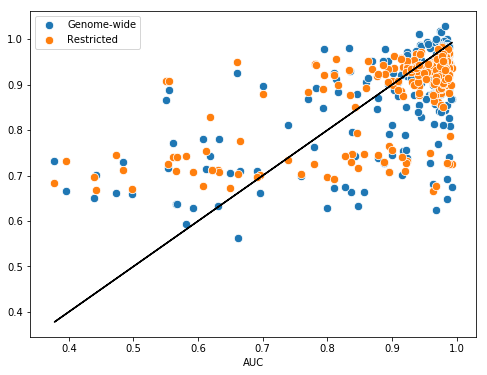

In [32]:
# Plot predicted vs. actual AUC for both models
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(x=y_test_both, y=preds_gw, s=70, label="Genome-wide")
sns.scatterplot(x=y_test_both, y=preds_restricted, s=70, label = "Restricted")
ax.plot(y_test_both, y_test_both, color="black")

plt.show()

### Feature importances - PG EN model

In [153]:
# Load corresponding ModelingResults object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "pathway_genes-enet_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name, len(restricted_results.performance_dict))

Pathway genes - modeling with ENet over few data splits 186


In [154]:
# Generate full data for restricted model
drug_name = "Methotrexate"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

drugs = DrugWithGenesInSamePathways.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets, 
                                       map_target_genes_to_same_pathways_genes)
drug_restricted = drugs[drug_tuple[1]]
del drugs
# Create full data for restricted model
# Set up data classes we want to use
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.return_full_data(drug_response_df,
                     gene_expression_df=gene_expression_df,
                     cnv_binary_df=cnv_binary_df,
                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                     cell_line_list=cell_lines_list_df,
                     mutation_df=coding_variants_df,
                     data_combination=data_types)

print("Shape of created restricted data:", data_restricted.shape)

# Initialize proper estimator
estimator = ElasticNet()
importances, cols = restricted_results.extract_feature_importances_across_splits(data_restricted, 
                                                                                     drug_tuple,
                                                                                     estimator, log=False)
print(len(importances), len(cols))
sorted_importances = ModelingResults.sort_feature_importances(importances, cols, 
                                                              map_ensembl_to_hgnc)
print(sorted_importances[:5])

Shape of created restricted data: (795, 84)
82 82
[('Tissue_blood', -0.04479748663565497), ('CDT1_exp', -0.011005828289040264), ('DHFR2_exp', -0.00802767433719596), ('SLC19A1_exp', -0.007153181057237864), ('SHMT2_exp', -0.006836981657045714)]


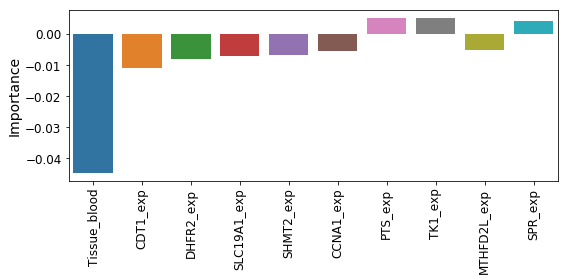

In [156]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW AF EN model

In [157]:
# Load previously computed feature importances
drug_name = "Methotrexate"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_all_features_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

18613 [('IL2RA_exp', -0.0027711958205009204), ('EDEM1_exp', -0.002414438419742152), ('DARS_exp', -0.0021789722315150827)]


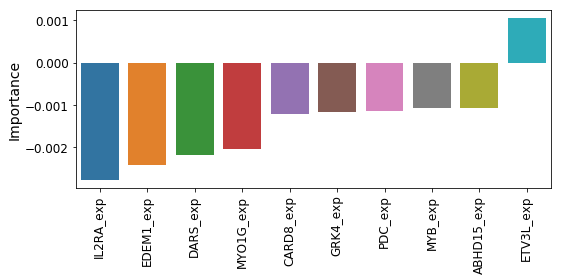

In [158]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW EN model

In [159]:
# Load previously computed feature importances
drug_name = "Methotrexate"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

17737 [('IGHV4-34_exp', -0.00030987773260831593), ('KBTBD11_exp', -0.000293543055454143), ('HMX2_exp', -0.00028298897409493635)]


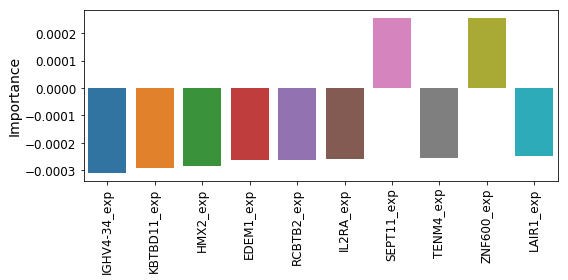

In [160]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

# SN-38

### Scatterplots predicted vs. actual - GW EN and PG + S EN

In [64]:
# Load corresponding best ModelingResults object
# Set directory with results
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "pathway_genes_with_signatures-enet_over_few_data_splits_limited.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name)
print(len(restricted_results.performance_dict))

Pathway genes with signatures - modeling with ENet over few data splits
186


In [66]:
# Check raw results per splits
mods = ["GW EN", "PG + S EN"]
df_raw_all_models_filtered[
    (df_raw_all_models_filtered["Drug Name"] == "SN-38") & df_raw_all_models_filtered.Model.isin(mods)
].sort_values("Split seed")

,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
6140,1494,SN-38,11,0.167182,0.495500,3.911814e-18,0.191607,1.146103,DNA replication,PG + S EN,NaN
10780,1494,SN-38,11,0.144053,0.684941,4.425346e-41,0.196734,1.365706,DNA replication,GW EN,NaN
6141,1494,SN-38,37,0.165173,0.505113,6.879172e-19,0.190974,1.156205,DNA replication,PG + S EN,NaN
10781,1494,SN-38,37,0.170885,0.569319,4.695822e-26,0.205948,1.205184,DNA replication,GW EN,NaN
6142,1494,SN-38,52,0.183267,0.389046,3.451666e-11,0.198692,1.084169,DNA replication,PG + S EN,NaN
10782,1494,SN-38,52,0.165414,0.567576,7.148271e-26,0.201252,1.216658,DNA replication,GW EN,NaN
6143,1494,SN-38,71,0.188210,0.370424,3.312734e-10,0.202286,1.074787,DNA replication,PG + S EN,NaN
10783,1494,SN-38,71,0.153988,0.632829,1.615841e-33,0.199521,1.295692,DNA replication,GW EN,NaN
6144,1494,SN-38,98,0.186993,0.356378,1.662227e-09,0.200112,1.070160,DNA replication,PG + S EN,NaN
10784,1494,SN-38,98,0.156743,0.631576,2.358107e-33,0.201961,1.288488,DNA replication,GW EN,NaN


In [68]:
# Pick a split to work on
drug_tuple = ("SN-38", 1494)
split_seed = 98

estimator_seed_restricted = restricted_results.estimator_seeds[restricted_results.split_seeds.index(split_seed)]
estimator_seed_gw = genome_wide_without_selection_enet.estimator_seeds[genome_wide_without_selection_enet.split_seeds.index(split_seed)]
tuning_seed_restricted = restricted_results.tuning_seeds_dict[drug_tuple][split_seed]
tuning_seed_gw = genome_wide_without_selection_enet.tuning_seeds_dict[drug_tuple][split_seed]

In [70]:
# Perform both modelings
# Generate full data for both models
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
drug_gw = drugs[drug_tuple[1]]
del drugs
drugs = DrugWithGenesInSamePathways.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets, 
                                       map_target_genes_to_same_pathways_genes)
drug_restricted = drugs[drug_tuple[1]]
del drugs


# Create full data for GW model
data_gw = drug_gw.return_full_data(drug_response_df, gene_expression_df, data_combination=["expression"])
print("Shape of created GW data:", data_gw.shape)

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue", "merck signatures"]
data_restricted = drug_restricted.return_full_data(drug_response_df,
                     gene_expression_df=gene_expression_df,
                     cnv_binary_df=cnv_binary_df,
                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                     cell_line_list=cell_lines_list_df,
                     mutation_df=coding_variants_df,
                     merck_signatures_df=signatures_df,
                     data_combination=data_types)

print("Shape of created restricted data:", data_restricted.shape)

X_train_gw, X_test_gw, X_train_restricted, X_test_restricted, y_train_both, y_test_both = ModelingResults.prepare_data_for_scatter_plots(
data_gw, data_restricted, split_seed)
print("X_train_gw and X_train_restricted shape:", X_train_gw.shape, X_train_restricted.shape)
print("X_test_gw and X_test_restricted shape:", X_test_gw.shape, X_test_restricted.shape)
print("y_both_train and y_both_test shape:", y_train_both.shape, y_test_both.shape)
print(y_test_both.sum())

Shape of created GW data: (956, 17739)
Shape of created restricted data: (897, 197)
X_train_gw and X_train_restricted shape: (627, 17737) (627, 195)
X_test_gw and X_test_restricted shape: (270, 17737) (270, 195)
y_both_train and y_both_test shape: (627,) (270,)
177.63672300000002


In [72]:
# Modeling with best parameters - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

# Extract best parameters
best_params = genome_wide_without_selection_enet.best_params_dict[drug_tuple][split_seed]
print(best_params)

preds_gw = ModelingResults.model_for_scatter_plots_with_best_params(X_train_gw, X_test_gw, y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.1, 'estimator__alpha': 0.1}
Test correlation: (0.5493218717901347, 1.099219749004163e-22)
Test RMSE: 0.1675253278247923


In [ ]:
# Modeling with grid search - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

preds_gw = ModelingResults.model_for_scatter_plots(X_train_gw, X_test_gw, 
                                   y_train_both, y_test_both, estimator,
                                   genome_wide_without_selection_enet.param_grid, 
                                   tuning_seed_restricted,
                                   log=True)

In [76]:
# Modeling with best parameters - restricted

# Extract best parameters
best_params = restricted_results.best_params_dict[drug_tuple][split_seed]
print(best_params)

estimator = ElasticNet(random_state=estimator_seed_restricted, max_iter=2500)


preds_restricted = ModelingResults.model_for_scatter_plots_with_best_params(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.1, 'estimator__alpha': 0.1}
Test correlation: (0.3563778011670847, 1.6622281501523807e-09)
Test RMSE: 0.1869926203756732


In [74]:
# Modeling with grid search - restricted
estimator = ElasticNet(random_state=estimator_seed_restricted, max_iter=2500)

preds_restricted = ModelingResults.model_for_scatter_plots(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator,
                                   restricted_results.param_grid, tuning_seed_restricted,
                                   log=True)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Test correlation: (0.3563778011670847, 1.6622281501523807e-09)
Test RMSE: 0.1869926203756732
{'estimator__l1_ratio': 0.1, 'estimator__alpha': 0.1}


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   10.7s finished


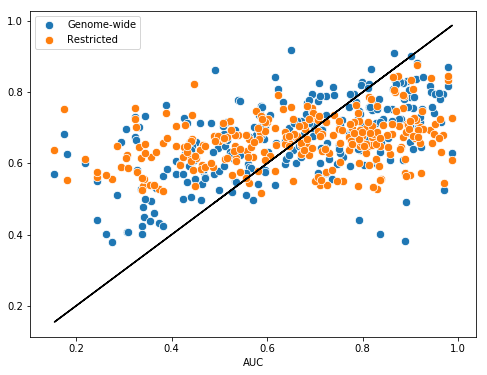

In [77]:
# Plot predicted vs. actual AUC for both models
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(x=y_test_both, y=preds_gw, s=70, label="Genome-wide")
sns.scatterplot(x=y_test_both, y=preds_restricted, s=70, label = "Restricted")
ax.plot(y_test_both, y_test_both, color="black")

plt.show()

### Feature importances - PG + S EN model

In [161]:
# Load corresponding ModelingResults object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "pathway_genes_with_signatures-enet_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name, len(restricted_results.performance_dict))

Pathway genes with signatures - modeling with ENet over few data splits 266


In [162]:
# Generate full data for restricted model
drug_name = "SN-38"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

drugs = DrugWithGenesInSamePathways.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets, 
                                       map_target_genes_to_same_pathways_genes)
drug_restricted = drugs[drug_tuple[1]]
del drugs
# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue", "merck signatures"]
data_restricted = drug_restricted.return_full_data(drug_response_df,
                     gene_expression_df=gene_expression_df,
                     cnv_binary_df=cnv_binary_df,
                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                     cell_line_list=cell_lines_list_df,
                     mutation_df=coding_variants_df,
                     merck_signatures_df=signatures_df,
                     data_combination=data_types)

print("Shape of created restricted data:", data_restricted.shape)

# Initialize proper estimator
estimator = ElasticNet()
importances, cols = restricted_results.extract_feature_importances_across_splits(data_restricted, 
                                                                                     drug_tuple,
                                                                                     estimator, log=False)
print(len(importances), len(cols))
sorted_importances = ModelingResults.sort_feature_importances(importances, cols, 
                                                              map_ensembl_to_hgnc)
print(sorted_importances[:5])

Shape of created restricted data: (897, 197)
195 195
[('cnaPANCAN280', 0.013938578558233768), ('AKT.up.Creighton2007', 0.013112245908953943), ('Hou2010_LuCa_ADC', 0.012477714715600973), ('Tissue_lung', 0.011399165782342107), ('TNFa_NFkB_pw_response.Tian2005', -0.00983383166111597)]


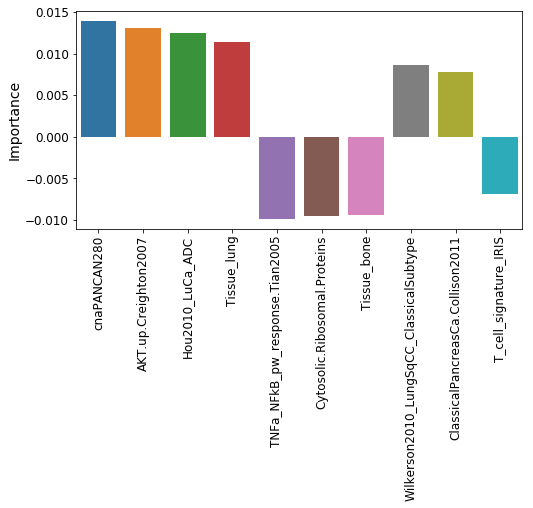

In [163]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW AF EN model

In [164]:
# Load previously computed feature importances
drug_name = "SN-38"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_all_features_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

18613 [('SLFN11_exp', -0.07894965097418441), ('PKP4_exp', 0.008034436360398902), ('ACBD3_exp', 0.007628666670299157)]


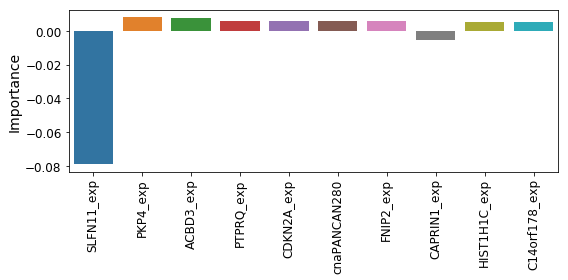

In [165]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW EN model

In [166]:
# Load previously computed feature importances
drug_name = "SN-38"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

17737 [('SLFN11_exp', -0.0721547613756618), ('KCNMB2_exp', 0.0104679701073836), ('ABCG2_exp', 0.008663311676724048)]


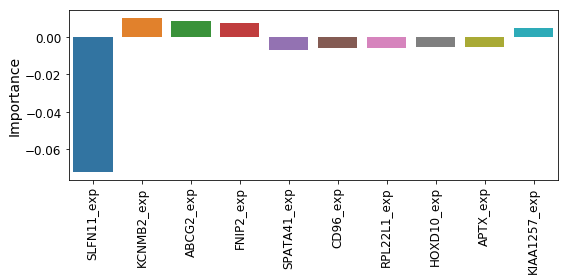

In [167]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

# Afatinib

### Scatterplots predicted vs. actual - GW EN and OT EN

In [78]:
# Load corresponding best ModelingResults object
# Set directory with results
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "only_targets-enet_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name)

Only targets - modeling with ENet over few data splits


In [80]:
# Check raw results per splits
mods = ["GW EN", "OT EN"]
df_raw_all_models_filtered[
    (df_raw_all_models_filtered["Drug Name"] == "Afatinib") & df_raw_all_models_filtered.Model.isin(mods)
].sort_values("Split seed")

,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
855,1377,Afatinib,11,0.122921,0.627933,8.244365e-30,0.157696,1.282909,EGFR signaling,OT EN,NaN
10770,1377,Afatinib,11,0.120374,0.578000,5.323054e-26,0.147502,1.225360,EGFR signaling,GW EN,NaN
856,1377,Afatinib,37,0.144340,0.631339,3.290589e-30,0.181713,1.258923,EGFR signaling,OT EN,NaN
10771,1377,Afatinib,37,0.142353,0.551359,2.373914e-23,0.165110,1.159866,EGFR signaling,GW EN,NaN
857,1377,Afatinib,52,0.127508,0.598639,1.421155e-26,0.158803,1.245427,EGFR signaling,OT EN,NaN
10772,1377,Afatinib,52,0.127730,0.554997,1.065660e-23,0.152312,1.192453,EGFR signaling,GW EN,NaN
858,1377,Afatinib,71,0.120867,0.617505,1.280400e-28,0.150450,1.244758,EGFR signaling,OT EN,NaN
10773,1377,Afatinib,71,0.124219,0.584450,1.115992e-26,0.152642,1.228811,EGFR signaling,GW EN,NaN
859,1377,Afatinib,98,0.110359,0.593935,4.383450e-26,0.136662,1.238338,EGFR signaling,OT EN,NaN
10774,1377,Afatinib,98,0.133153,0.563236,1.674208e-24,0.161107,1.209945,EGFR signaling,GW EN,NaN


In [81]:
# Pick a split to work on
drug_tuple = ("Afatinib", 1377)
split_seed = 37

estimator_seed_restricted = restricted_results.estimator_seeds[restricted_results.split_seeds.index(split_seed)]
estimator_seed_gw = genome_wide_without_selection_enet.estimator_seeds[genome_wide_without_selection_enet.split_seeds.index(split_seed)]
tuning_seed_restricted = restricted_results.tuning_seeds_dict[drug_tuple][split_seed]
tuning_seed_gw = genome_wide_without_selection_enet.tuning_seeds_dict[drug_tuple][split_seed]

In [82]:
# Perform both modelings
# Generate full data for both models
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
drug_gw = drugs[drug_tuple[1]]
del drugs
drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)
drug_restricted = drugs[drug_tuple[1]]
del drugs


# Create full data for GW model
data_gw = drug_gw.return_full_data(drug_response_df, gene_expression_df, data_combination=["expression"])
print("Shape of created GW data:", data_gw.shape)

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df)

print("Shape of created restricted data:", data_restricted.shape)

X_train_gw, X_test_gw, X_train_restricted, X_test_restricted, y_train_both, y_test_both = ModelingResults.prepare_data_for_scatter_plots(
data_gw, data_restricted, split_seed)
print("X_train_gw and X_train_restricted shape:", X_train_gw.shape, X_train_restricted.shape)
print("X_test_gw and X_test_restricted shape:", X_test_gw.shape, X_test_restricted.shape)
print("y_both_train and y_both_test shape:", y_train_both.shape, y_test_both.shape)
print(y_test_both.sum())

Shape of created GW data: (917, 17739)
Shape of created restricted data: (862, 21)
X_train_gw and X_train_restricted shape: (603, 17737) (603, 19)
X_test_gw and X_test_restricted shape: (259, 17737) (259, 19)
y_both_train and y_both_test shape: (603,) (259,)
229.99085300000002


In [84]:
# Modeling with best parameters - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

# Extract best parameters
best_params = genome_wide_without_selection_enet.best_params_dict[drug_tuple][split_seed]
print(best_params)

preds_gw = ModelingResults.model_for_scatter_plots_with_best_params(X_train_gw, X_test_gw, y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.25, 'estimator__alpha': 0.1}
Test correlation: (0.5445946671920411, 2.105774004947086e-21)
Test RMSE: 0.15955560908784316


In [ ]:
# Modeling with grid search - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

preds_gw = ModelingResults.model_for_scatter_plots(X_train_gw, X_test_gw, 
                                   y_train_both, y_test_both, estimator,
                                   genome_wide_without_selection_enet.param_grid, 
                                   tuning_seed_restricted,
                                   log=True)

In [85]:
# Modeling with best parameters - restricted

# Extract best parameters
best_params = restricted_results.best_params_dict[drug_tuple][split_seed]
print(best_params)

estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)


preds_restricted = ModelingResults.model_for_scatter_plots_with_best_params(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.1, 'estimator__alpha': 0.01}
Test correlation: (0.6313394003431928, 3.290588765010247e-30)
Test RMSE: 0.1443402565116493


In [ ]:
# Modeling with grid search - restricted
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

preds_restricted = ModelingResults.model_for_scatter_plots(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator,
                                   restricted_results.param_grid, tuning_seed_restricted,
                                   log=True)

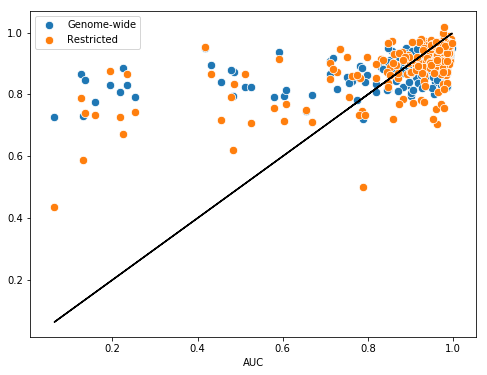

In [86]:
# Plot predicted vs. actual AUC for both models
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(x=y_test_both, y=preds_gw, s=70, label="Genome-wide")
sns.scatterplot(x=y_test_both, y=preds_restricted, s=70, label = "Restricted")
ax.plot(y_test_both, y_test_both, color="black")

plt.show()

### Feature importances - OT EN model

In [168]:
# Load corresponding ModelingResults object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "only_targets-enet_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name, len(restricted_results.performance_dict))

Only targets - modeling with ENet over few data splits 184


In [169]:
# Generate full data for restricted model
drug_name = "Afatinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)
drug_restricted = drugs[drug_tuple[1]]
del drugs
# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df)
print("Shape of created restricted data:", data_restricted.shape)

# Initialize proper estimator
estimator = ElasticNet()
importances, cols = restricted_results.extract_feature_importances_across_splits(data_restricted, 
                                                                                     drug_tuple,
                                                                                     estimator, log=False)
print(len(importances), len(cols))
sorted_importances = ModelingResults.sort_feature_importances(importances, cols, 
                                                              map_ensembl_to_hgnc)
print(sorted_importances[:5])

Shape of created restricted data: (862, 21)
19 19
[('ERBB2_exp', -0.06850106623653877), ('EGFR_exp', -0.03938342555899284), ('Tissue_aero_digestive_tract', -0.026822315535863967), ('EGFR_mut', -0.011935290167581153), ('Tissue_kidney', -0.010740162402799888)]


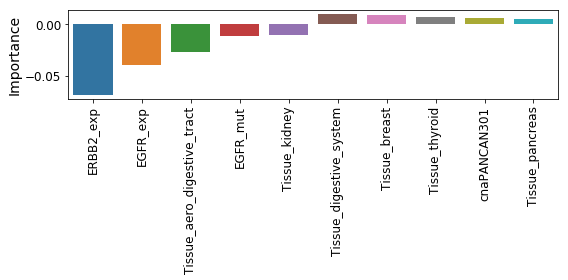

In [170]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW AF EN model

In [171]:
# Load previously computed feature importances
drug_name = "Afatinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_all_features_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

18613 [('ERBB2_exp', -0.0051991499652617075), ('ITGB6_exp', -0.0032128475234889874), ('EGFR_exp', -0.0031888927757427695)]


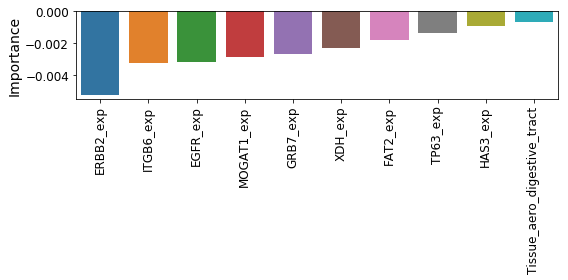

In [172]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW EN model

In [173]:
# Load previously computed feature importances
drug_name = "Afatinib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

17737 [('ERBB2_exp', -0.020277738437903148), ('ITGB6_exp', -0.006489581732399016), ('XDH_exp', -0.005142382420081656)]


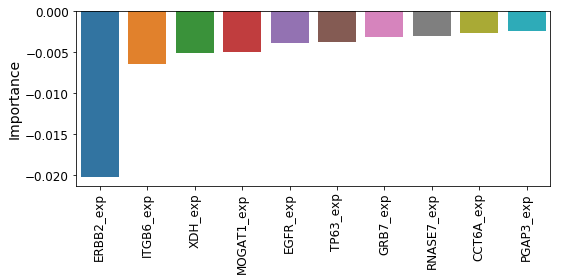

In [174]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

# Linifanib

### Scatterplots predicted vs. actual - GW EN and OT RF

In [12]:
# Load corresponding best ModelingResults object
# Set directory with results
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "only_targets-rforest_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(type(restricted_results))

<class 'gdsc_projects_module.ModelingResults'>


In [13]:
# Check raw results per splits
mods = ["GW EN", "OT RF"]
df_raw_all_models_filtered[
    (df_raw_all_models_filtered["Drug Name"] == "Linifanib") & df_raw_all_models_filtered.Model.isin(mods)
].sort_values("Split seed")

,Drug ID,Drug Name,Split seed,Model test RMSE,Model test correlation,Correlation pval,Dummy test RMSE,Relative test RMSE,Target Pathway,Model,Best k
1290,277,Linifanib,11,0.040287,0.679065,2.282993e-36,0.054016,1.340784,RTK signaling,OT RF,NaN
10160,277,Linifanib,11,0.074011,0.065745,2.755180e-01,0.054504,0.736435,RTK signaling,GW EN,NaN
1291,277,Linifanib,37,0.058166,0.507882,2.173485e-18,0.064333,1.106031,RTK signaling,OT RF,NaN
10161,277,Linifanib,37,0.056273,0.574566,9.850037e-26,0.067533,1.200091,RTK signaling,GW EN,NaN
1292,277,Linifanib,52,0.059609,0.799694,7.134313e-59,0.090647,1.520673,RTK signaling,OT RF,NaN
10162,277,Linifanib,52,0.077493,0.564351,1.069813e-24,0.089727,1.157883,RTK signaling,GW EN,NaN
1293,277,Linifanib,71,0.078949,0.847353,1.328436e-72,0.107754,1.364860,RTK signaling,OT RF,NaN
10163,277,Linifanib,71,0.057711,0.227919,1.298973e-04,0.056846,0.985018,RTK signaling,GW EN,NaN
1294,277,Linifanib,98,0.041992,0.914344,6.828002e-103,0.087529,2.084421,RTK signaling,OT RF,NaN
10164,277,Linifanib,98,0.061493,0.510149,9.308647e-20,0.068039,1.106450,RTK signaling,GW EN,NaN


In [14]:
# Pick a split to work on
drug_tuple = ("Linifanib", 277)
split_seed = 98

estimator_seed_restricted = restricted_results.estimator_seeds[restricted_results.split_seeds.index(split_seed)]
estimator_seed_gw = genome_wide_without_selection_enet.estimator_seeds[genome_wide_without_selection_enet.split_seeds.index(split_seed)]
tuning_seed_restricted = restricted_results.tuning_seeds_dict[drug_tuple][split_seed]
tuning_seed_gw = genome_wide_without_selection_enet.tuning_seeds_dict[drug_tuple][split_seed]

In [15]:
# Perform both modelings
# Generate full data for both models
drugs = DrugGenomeWide.create_drugs(drug_annotations_df)
drug_gw = drugs[drug_tuple[1]]
del drugs
drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)
drug_restricted = drugs[drug_tuple[1]]
del drugs


# Create full data for GW model
data_gw = drug_gw.return_full_data(drug_response_df, gene_expression_df, data_combination=["expression"])
print("Shape of created GW data:", data_gw.shape)

# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df)

print("Shape of created restricted data:", data_restricted.shape)

X_train_gw, X_test_gw, X_train_restricted, X_test_restricted, y_train_both, y_test_both = ModelingResults.prepare_data_for_scatter_plots(
data_gw, data_restricted, split_seed)
print("X_train_gw and X_train_restricted shape:", X_train_gw.shape, X_train_restricted.shape)
print("X_test_gw and X_test_restricted shape:", X_test_gw.shape, X_test_restricted.shape)
print("y_both_train and y_both_test shape:", y_train_both.shape, y_test_both.shape)
print(y_test_both.sum())

Shape of created GW data: (922, 17739)
Shape of created restricted data: (863, 21)
X_train_gw and X_train_restricted shape: (604, 17737) (604, 19)
X_test_gw and X_test_restricted shape: (259, 17737) (259, 19)
y_both_train and y_both_test shape: (604,) (259,)
250.403593


In [42]:
# Modeling with best parameters - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

# Extract best parameters
best_params = genome_wide_without_selection_enet.best_params_dict[drug_tuple][split_seed]
print(best_params)

preds_gw = ModelingResults.model_for_scatter_plots_with_best_params(X_train_gw, X_test_gw, y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__l1_ratio': 0.0, 'estimator__alpha': 1.0}
Test correlation: (0.500541123023562, 7.894104981543652e-18)
Test RMSE: 0.07664804573518841


In [ ]:
# Modeling with grid search - genome wide
estimator = ElasticNet(random_state=estimator_seed_gw, max_iter=2500)

preds_gw = ModelingResults.model_for_scatter_plots(X_train_gw, X_test_gw, 
                                   y_train_both, y_test_both, estimator,
                                   genome_wide_without_selection_enet.param_grid, 
                                   tuning_seed_restricted,
                                   log=True)

In [43]:
# Modeling with best parameters - restricted

# Extract best parameters
best_params = restricted_results.best_params_dict[drug_tuple][split_seed]
print(best_params)

estimator = RandomForestRegressor(random_state=estimator_seed_restricted)


preds_restricted = ModelingResults.model_for_scatter_plots_with_best_params(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator, 
                                   best_params, log=True)

{'estimator__n_estimators': 50, 'estimator__min_samples_split': 46, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 'auto', 'estimator__max_depth': 40, 'estimator__criterion': 'mse'}
Test correlation: (0.9143436196327063, 6.828002041111783e-103)
Test RMSE: 0.041992156925110186


In [37]:
# Modeling with grid search - restricted
estimator = RandomForestRegressor(random_state=estimator_seed_restricted)


preds_restricted = ModelingResults.model_for_scatter_plots(X_train_restricted, X_test_restricted, 
                                   y_train_both, y_test_both, estimator,
                                   restricted_results.param_grid, tuning_seed_restricted,
                                   log=True)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Test correlation: (0.9143436196327063, 6.828002041111783e-103)
Test RMSE: 0.041992156925110186
{'estimator__n_estimators': 50, 'estimator__min_samples_split': 46, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 'auto', 'estimator__max_depth': 40, 'estimator__criterion': 'mse'}


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   15.2s finished


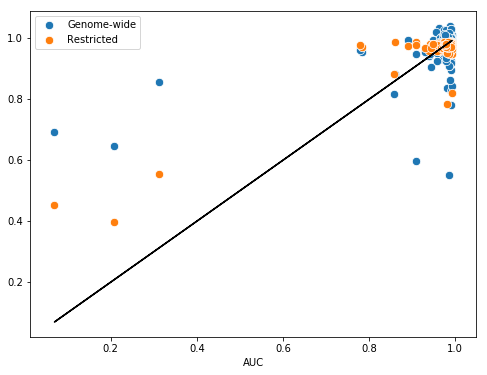

In [44]:
# Plot predicted vs. actual AUC for both models
plt.figure(figsize=(8, 6))

ax = sns.scatterplot(x=y_test_both, y=preds_gw, s=70, label="Genome-wide")
sns.scatterplot(x=y_test_both, y=preds_restricted, s=70, label = "Restricted")
ax.plot(y_test_both, y_test_both, color="black")

plt.show()

In [16]:
# Check out samples in detail
print(y_test_both.sort_values()[:5])

394    0.069205
268    0.208064
389    0.312973
490    0.778055
635    0.783000
Name: AUC, dtype: float64


In [17]:
print(map_ensembl_to_hgnc["ENSG00000122025"])
print(map_ensembl_to_hgnc["ENSG00000157404"])
print(map_ensembl_to_hgnc["ENSG00000182578"])
print(data_restricted["ENSG00000122025"].mean(), data_restricted["ENSG00000122025"].std())
data_restricted[
    data_restricted.AUC == 0.312973
]

FLT3_exp
KIT_exp
CSF1R_exp
3.302587790300313 1.2742060220441926


,cell_line_id,FLT3_mut,KIT_mut,ENSG00000122025,ENSG00000157404,ENSG00000182578,cnaPANCAN382,Tissue_aero_digestive_tract,Tissue_blood,Tissue_bone,...,Tissue_digestive_system,Tissue_kidney,Tissue_lung,Tissue_nervous_system,Tissue_pancreas,Tissue_skin,Tissue_soft_tissue,Tissue_thyroid,Tissue_urogenital_system,AUC
368,908148,0,0,12.2967,2.99955,2.9448,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0.312973


In [18]:
# Write important cell lines ID
sensitive_cell_lines = [908156, 906856, 908148]

In [19]:
col_mapper = {}
for ensembl, hgnc in map_ensembl_to_hgnc.items():
    if hgnc in ["FLT3_exp", "KIT_exp", "CSF1R_exp"]:
        col_mapper[ensembl] = hgnc
print(col_mapper)

{'ENSG00000122025': 'FLT3_exp', 'ENSG00000157404': 'KIT_exp', 'ENSG00000182578': 'CSF1R_exp'}


In [20]:
data_restricted = data_restricted.rename(columns=col_mapper)
data_restricted.describe()

,cell_line_id,FLT3_mut,KIT_mut,cnaPANCAN382,Tissue_aero_digestive_tract,Tissue_blood,Tissue_bone,Tissue_breast,Tissue_digestive_system,Tissue_kidney,Tissue_lung,Tissue_nervous_system,Tissue_pancreas,Tissue_skin,Tissue_soft_tissue,Tissue_thyroid,Tissue_urogenital_system,AUC
count,8.630000e+02,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000,863.000000
mean,9.850587e+05,0.012746,0.004635,0.023175,0.088065,0.156431,0.037080,0.054461,0.103129,0.032445,0.199305,0.090382,0.034762,0.061414,0.019699,0.016222,0.106605,0.969205
std,2.182368e+05,0.112242,0.067962,0.150546,0.283554,0.363474,0.189067,0.227057,0.304303,0.177281,0.399709,0.286895,0.183284,0.240227,0.139043,0.126403,0.308789,0.078661
min,6.836650e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050919
25%,9.067925e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.975237
50%,9.097120e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.982009
75%,1.240136e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.986445
max,1.674021e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998628


In [21]:
X_train_restricted = X_train_restricted.rename(columns=col_mapper)
X_train_restricted[["FLT3_exp", "KIT_exp", "CSF1R_exp"]].mean()

FLT3_exp     3.298475
KIT_exp      3.236067
CSF1R_exp    2.998282
dtype: float64

In [22]:
print(X_train_restricted.shape)
restricted_data_train = data_restricted.loc[X_train_restricted.index]
print(restricted_data_train.shape)

print(X_test_restricted.shape)
restricted_data_test = data_restricted.loc[X_test_restricted.index]
print(restricted_data_test.shape)

(604, 19)
(604, 21)
(259, 19)
(259, 21)


In [23]:
restricted_data_train[["FLT3_exp", "KIT_exp", "CSF1R_exp"]].std()

FLT3_exp     1.239609
KIT_exp      0.681578
CSF1R_exp    0.229528
dtype: float64

In [24]:
restricted_data_train[["FLT3_exp", "KIT_exp", "CSF1R_exp"]].mean()

FLT3_exp     3.298475
KIT_exp      3.236067
CSF1R_exp    2.998282
dtype: float64

In [25]:
sensitive_df = restricted_data_test[restricted_data_test.cell_line_id.isin(sensitive_cell_lines)]
sensitive_df[["FLT3_exp", "KIT_exp", "CSF1R_exp"]].mean()

FLT3_exp     11.532187
KIT_exp       3.242039
CSF1R_exp     3.682201
dtype: float64

In [28]:
# Rename columns of data gw
col_mapper = {}
for col in data_gw.columns:
    if col in map_ensembl_to_hgnc:
        col_mapper[col] = map_ensembl_to_hgnc[col]
    else:
        col_mapper[col] = col
print(len(col_mapper))

17739


In [29]:
data_gw = data_gw.rename(columns=col_mapper)
data_gw.head()

,cell_line_id,TSPAN6_exp,TNMD_exp,DPM1_exp,SCYL3_exp,C1orf112_exp,FGR_exp,CFH_exp,FUCA2_exp,GCLC_exp,...,PPY2P_exp,ENSG00000265246,ENSG00000265298,KRT18P55_exp,MIR5195_exp,POLRMTP1_exp,UBL5P2_exp,TBC1D3P5_exp,ENSG00000266753,AUC
0,683665,3.23827,2.98225,10.2355,4.85606,4.07887,9.11624,3.65859,6.14548,5.04246,...,3.09572,3.50251,8.56432,3.27437,4.01807,3.05621,9.44631,3.53087,6.13427,0.988865
1,683667,7.78071,2.75325,9.96014,4.35107,3.71674,3.22228,8.22161,3.82347,4.75623,...,3.23071,3.03245,9.04097,3.10209,2.87087,3.16919,9.81043,3.26691,8.45208,0.978526
2,684052,7.30134,2.89053,9.92249,4.12509,3.67899,3.09658,3.58839,4.8093,4.95178,...,3.00352,2.87474,8.53276,3.06819,2.87407,3.13548,9.07322,3.09836,6.82424,0.989661
3,684055,8.6902,3.09147,9.99249,4.5722,3.33339,3.32079,3.15949,3.51511,5.44636,...,3.11474,3.12052,8.59165,3.11965,2.58867,3.19493,9.01322,3.07419,8.17305,0.982872
4,684057,8.2331,2.82469,10.0159,4.74971,3.83943,3.14275,5.32983,3.27212,5.53806,...,3.03186,3.37046,8.93082,3.32245,3.08392,2.81344,8.8932,3.26618,8.75829,0.978908


In [32]:
important_gw_genes = ["OCSTAMP_exp", "PPP1R27_exp", "CSF1R_exp", "TIFAB_exp", "CD300LF_exp"]
print(X_train_gw.shape)
gw_data_train = data_gw.loc[X_train_gw.index]
print(gw_data_train.shape)

print(X_test_gw.shape)
gw_data_test = data_gw.loc[X_test_gw.index]
print(gw_data_test.shape)

(604, 17737)
(604, 17739)
(259, 17737)
(259, 17739)


In [33]:
# Check out std and mean in training gw data for important gw genes
gw_data_train[important_gw_genes].std()

OCSTAMP_exp    0.398480
PPP1R27_exp    0.732868
CSF1R_exp      0.229528
TIFAB_exp      0.294117
CD300LF_exp    0.499953
dtype: float64

In [34]:
gw_data_train[important_gw_genes].mean()

OCSTAMP_exp    3.027970
PPP1R27_exp    3.209453
CSF1R_exp      2.998282
TIFAB_exp      2.867654
CD300LF_exp    3.363762
dtype: float64

In [36]:
sensitive_df = gw_data_test[gw_data_test.cell_line_id.isin(sensitive_cell_lines)]
sensitive_df[["cell_line_id"] + important_gw_genes]

,cell_line_id,OCSTAMP_exp,PPP1R27_exp,CSF1R_exp,TIFAB_exp,CD300LF_exp
389,908148,6.5737,11.5711,2.9448,2.90938,5.89743
268,906856,5.66491,9.85759,4.42947,5.42105,6.98542
394,908156,7.53411,10.3665,3.67233,7.6399,7.45084


In [37]:
sensitive_df[important_gw_genes].mean()

OCSTAMP_exp     6.590906
PPP1R27_exp    10.598379
CSF1R_exp       3.682201
TIFAB_exp       5.323444
CD300LF_exp     6.777895
dtype: float64

In [38]:
sensitive_df[important_gw_genes].mean() / gw_data_train[important_gw_genes].std()

OCSTAMP_exp    16.540135
PPP1R27_exp    14.461517
CSF1R_exp      16.042464
TIFAB_exp      18.099764
CD300LF_exp    13.557073
dtype: float64

In [41]:
data_restricted["FLT3_e"].mean()

3.302587790300313

In [52]:
print(preds_gw.argmin(), preds_gw.min())

32 0.5500016665451662


In [57]:
y_test_both.iloc[32:33]

856    0.98617
Name: AUC, dtype: float64

In [61]:
gw_data_test.loc[856]["cell_line_id"]

1330942

In [63]:
gw_data_test[gw_data_test.cell_line_id == 1330942][important_gw_genes]

,OCSTAMP_exp,PPP1R27_exp,CSF1R_exp,TIFAB_exp,CD300LF_exp
856,3.51675,3.7009,3.21012,2.97615,4.36256


### Feature importances - OT RF model

In [58]:
# Load corresponding ModelingResults object
filepath = "../Results Assesment/Final experimental raw results/"
with open(filepath + "only_targets-rforest_over_few_data_splits.pkl", "rb") as f:
    restricted_results = dill.load(f)
print(restricted_results.name, len(restricted_results.performance_dict))

Only targets - modeling with RForest over few data splits 184


In [59]:
# Generate full data for restricted model
drug_name = "Linifanib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

drugs = DrugWithDrugBank.create_drugs(drug_annotations_df, map_drugs_to_drugbank_targets)
drug_restricted = drugs[drug_tuple[1]]
del drugs
# Create full data for restricted model
data_types = ["CNV", "mutation", "expression", "tissue"]
data_restricted = drug_restricted.create_full_data(drug_response_df, data_combination=data_types, 
                                     gene_expression_df=gene_expression_df, 
                                     cnv_binary_df=cnv_binary_df,
                                     map_cl_id_and_feature_to_status=map_from_cl_id_and_genetic_feature_to_mutation_status,
                                     cell_line_list=cell_lines_list_df,
                                     mutation_df=coding_variants_df)

print("Shape of created restricted data:", data_restricted.shape)

# Initialize proper estimator
estimator = RandomForestRegressor()
importances, cols = restricted_results.extract_feature_importances_across_splits(data_restricted, 
                                                                                     drug_tuple,
                                                                                     estimator, log=False)
print(len(importances), len(cols))
sorted_importances = ModelingResults.sort_feature_importances(importances, cols,
                                                              map_ensembl_to_hgnc)
print(sorted_importances[:5])

Shape of created restricted data: (863, 21)
19 19
[('FLT3_exp', 0.4573726088982303), ('CSF1R_exp', 0.32994215265301363), ('KIT_exp', 0.11167289858362492), ('Tissue_blood', 0.047877901347935764), ('FLT3_mut', 0.030243122218875273)]


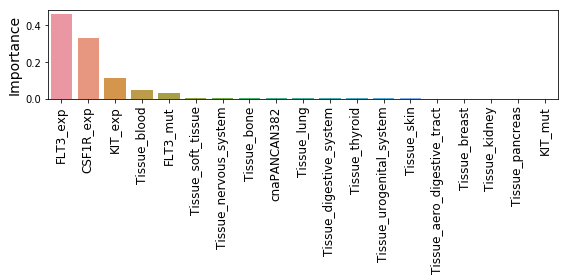

In [60]:
# Plot top k features along with their importances
k = 30

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=10)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# Check out specific features

### Feature importances - GW AF EN model

In [61]:
# Load previously computed feature importances
drug_name = "Linifanib"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_all_features_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

18613 [('OCSTAMP_exp', -0.005810096652869799), ('TIFAB_exp', -0.004961541414641568), ('U2AF1_mut', -0.00484819562887787)]


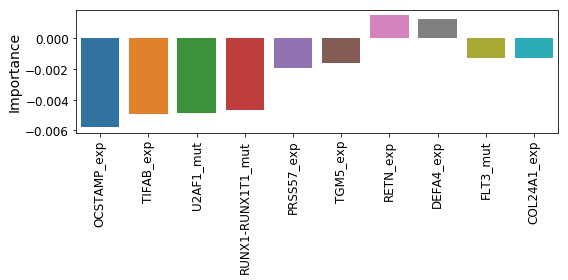

In [62]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

In [63]:
# Check out specific features
just_names = [x[0] for x in sorted_importances]
print(just_names.index("FLT3_exp"))

128


In [67]:
just_names.index("KIT_exp")

260

# Bleomycin (50 uM)

### Feature importances - GW AF EN model

In [182]:
# Load previously computed feature importances
drug_name = "Bleomycin (50 uM)"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_all_features_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

18613 [('SLFN11_exp', -0.0007436964408237488), ('MT1M_exp', -0.000600306912063085), ('GJC1_exp', -0.0005737499819792014)]


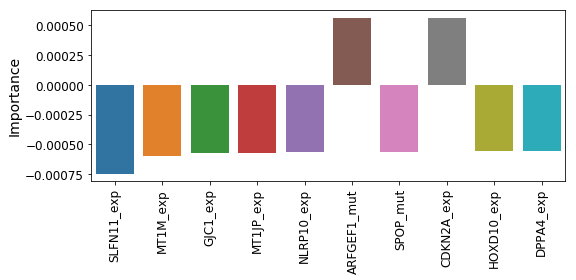

In [183]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()

### Feature importances - GW EN model

In [184]:
# Load previously computed feature importances
drug_name = "Bleomycin (50 uM)"
drug_id = df_doi[df_doi["Drug Name"] == drug_name]["Drug ID"].iloc[0]
drug_tuple = (drug_name, drug_id)

sorted_importances = genome_wide_without_selection_enet.feat_importances_dict[drug_tuple]
print(len(sorted_importances), sorted_importances[:3])

17737 [('SLFN11_exp', -0.0008658168360104544), ('CDKN2A_exp', 0.0007686066831736205), ('GJC1_exp', -0.0007467179425846279)]


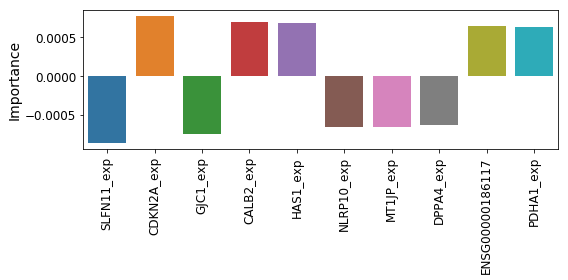

In [185]:
# Plot top k features along with their importances
k = 10

xs = [x[0] for x in sorted_importances[:k]]
ys = [x[1] for x in sorted_importances[:k]]

fig = plt.figure(figsize=(8, 4))
ax = sns.barplot(x=xs, y=ys)
ax.tick_params(axis="x", rotation=90, labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel("Importance", fontsize=14)

plt.tight_layout()
plt.show()